### Getting higher...

In this project I will try to use my ds/ml skills to solve a well-known regression problem. There will be a full pipeline of data preprocessing, feature development, and modeling. We will consider both simple classical methods (linear models) and modern approaches for solving this kind of problems (modern boosting algorithms such as catboost and lgbm).

This task should be an excellent practice of my skills

### Executive Summary

* Public score: 0.11968
* Top place: 187
* Persentil: 4.02%
* Model: 0.7*CatBoost + 0.25*BayesianRidge

### Importing

In [415]:
# core data-tules
import pandas as pd
import numpy as np
# stats tules
from scipy import stats
from statsmodels.regression import linear_model
# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# compare models
from pycaret import regression
# hyperparametrs tuning
import optuna 
# ML-tules
from missingpy import MissForest
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import IsolationForest
# ML-models
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, LinearRegression, Lasso, ElasticNet, BayesianRidge, OrthogonalMatchingPursuit
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, plot_importance
from catboost import CatBoostRegressor, Pool
# DL solution with pytorch
import torch as t
import torch.nn as nn

### Load the data

In [341]:
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

sns.set_style("dark")
sns.set(rc={'figure.figsize':(20,30)})

In [342]:
train0 = pd.read_csv("train.csv", index_col=0)
test0 = pd.read_csv("test.csv", index_col=0)

test_id = test0.index.array
train_id = train0.index.array
target = train0["SalePrice"]

train0 = train0.drop("SalePrice", axis=1)
data0 = pd.concat([train0, test0], axis=0)

### Changing dtypes and cleaning data

###### In the start of the work I prefer to look at the data and understand its structure from high point of view.

In [343]:
data1 = data0.copy()

In [344]:
dups = data1.duplicated()
dups.loc[dups]

Id
2714    True
2866    True
dtype: bool

In [345]:
data1.loc[[2714, 2866]]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2714,160,FV,24.0,2544,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,Twnhs,2Story,7,5,2005,2005,Gable,CompShg,MetalSd,MetalSd,None,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,600.0,600.0,GasA,Ex,Y,SBrkr,520,623,80,1223,0.0,0.0,2,1,2,1,Gd,4,Typ,0,NaN,Detchd,2005.0,RFn,2.0,480.0,TA,TA,Y,0,166,0,0,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal
2866,160,RM,24.0,2522,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Twnhs,2Story,7,5,2004,2004,Gable,CompShg,VinylSd,VinylSd,Stone,50.0,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,970.0,970.0,GasA,Ex,Y,SBrkr,970,739,0,1709,0.0,0.0,2,0,3,1,Gd,7,Maj1,0,NaN,Detchd,2004.0,Unf,2.0,380.0,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,5,2006,WD,Normal


In [346]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

We can see, that there a lot of missing values in the data (cover it in the future)

In [347]:
data1.select_dtypes("O")

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
4,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
5,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,RM,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,Gable,CompShg,CemntBd,CmentBd,None,TA,TA,CBlock,TA,TA,No,Unf,Unf,GasA,Gd,Y,SBrkr,TA,Typ,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,WD,Normal
2916,RM,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,Gable,CompShg,CemntBd,CmentBd,None,TA,TA,CBlock,TA,TA,No,Rec,Unf,GasA,TA,Y,SBrkr,TA,Typ,NaN,CarPort,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
2917,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml


In [348]:
data1.select_dtypes(np.number)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,548.0,0,61,0,0,0,0,0,2,2008
2,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,460.0,298,0,0,0,0,0,0,5,2007
3,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,608.0,0,42,0,0,0,0,0,9,2008
4,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,642.0,0,35,272,0,0,0,0,2,2006
5,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,836.0,192,84,0,0,0,0,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,21.0,1936,4,7,1970,1970,0.0,0.0,0.0,546.0,546.0,546,546,0,1092,0.0,0.0,1,1,3,1,5,0,NaN,0.0,0.0,0,0,0,0,0,0,0,6,2006
2916,160,21.0,1894,4,5,1970,1970,0.0,252.0,0.0,294.0,546.0,546,546,0,1092,0.0,0.0,1,1,3,1,6,0,1970.0,1.0,286.0,0,24,0,0,0,0,0,4,2006
2917,20,160.0,20000,5,7,1960,1996,0.0,1224.0,0.0,0.0,1224.0,1224,0,0,1224,1.0,0.0,1,0,4,1,7,1,1960.0,2.0,576.0,474,0,0,0,0,0,0,9,2006


There are features "MSSubClass", "MoSold", that we wanna see as categorical (not numerical)

In [349]:
#Changing dtypes for numeric features which show caregories
data1["MSSubClass"] = data1["MSSubClass"].map(str)
data1["MoSold"] = data1["MoSold"].map(str)

In [350]:
dataOnunique = data1.nunique()
features_to_bool = dataOnunique.loc[dataOnunique==2].index.values

In [351]:
data1[features_to_bool].isna().sum()/len(data1)

Street        0.000000
Alley         0.932169
Utilities     0.000685
CentralAir    0.000000
dtype: float64

In [352]:
data1.groupby("CentralAir")["MSSubClass"].count()

CentralAir
N     196
Y    2723
Name: MSSubClass, dtype: int64

And wa encode categorical features with 2 unique values as boolean

In [353]:
data1["Alley"] = data1["Alley"].fillna("none")
data1["IsStreePave"] = data1["Street"].map(lambda x: True if x == "Pave" else False)
data1["IsCentralAir"] = data1["CentralAir"].map(lambda x: True if x == "Y" else False)

In [354]:
data1 = data1.drop(["Street", "CentralAir"], axis = 1)
train1 = data1.loc[train_id]
test1 = data1.loc[test_id]

In [355]:
bool_features = data1.select_dtypes(bool).columns.array
cat_features = data1.select_dtypes("O").columns.array
num_features = data1.select_dtypes(np.number).columns.array

### EDA

###### In this block we will draw our data and get useful insights

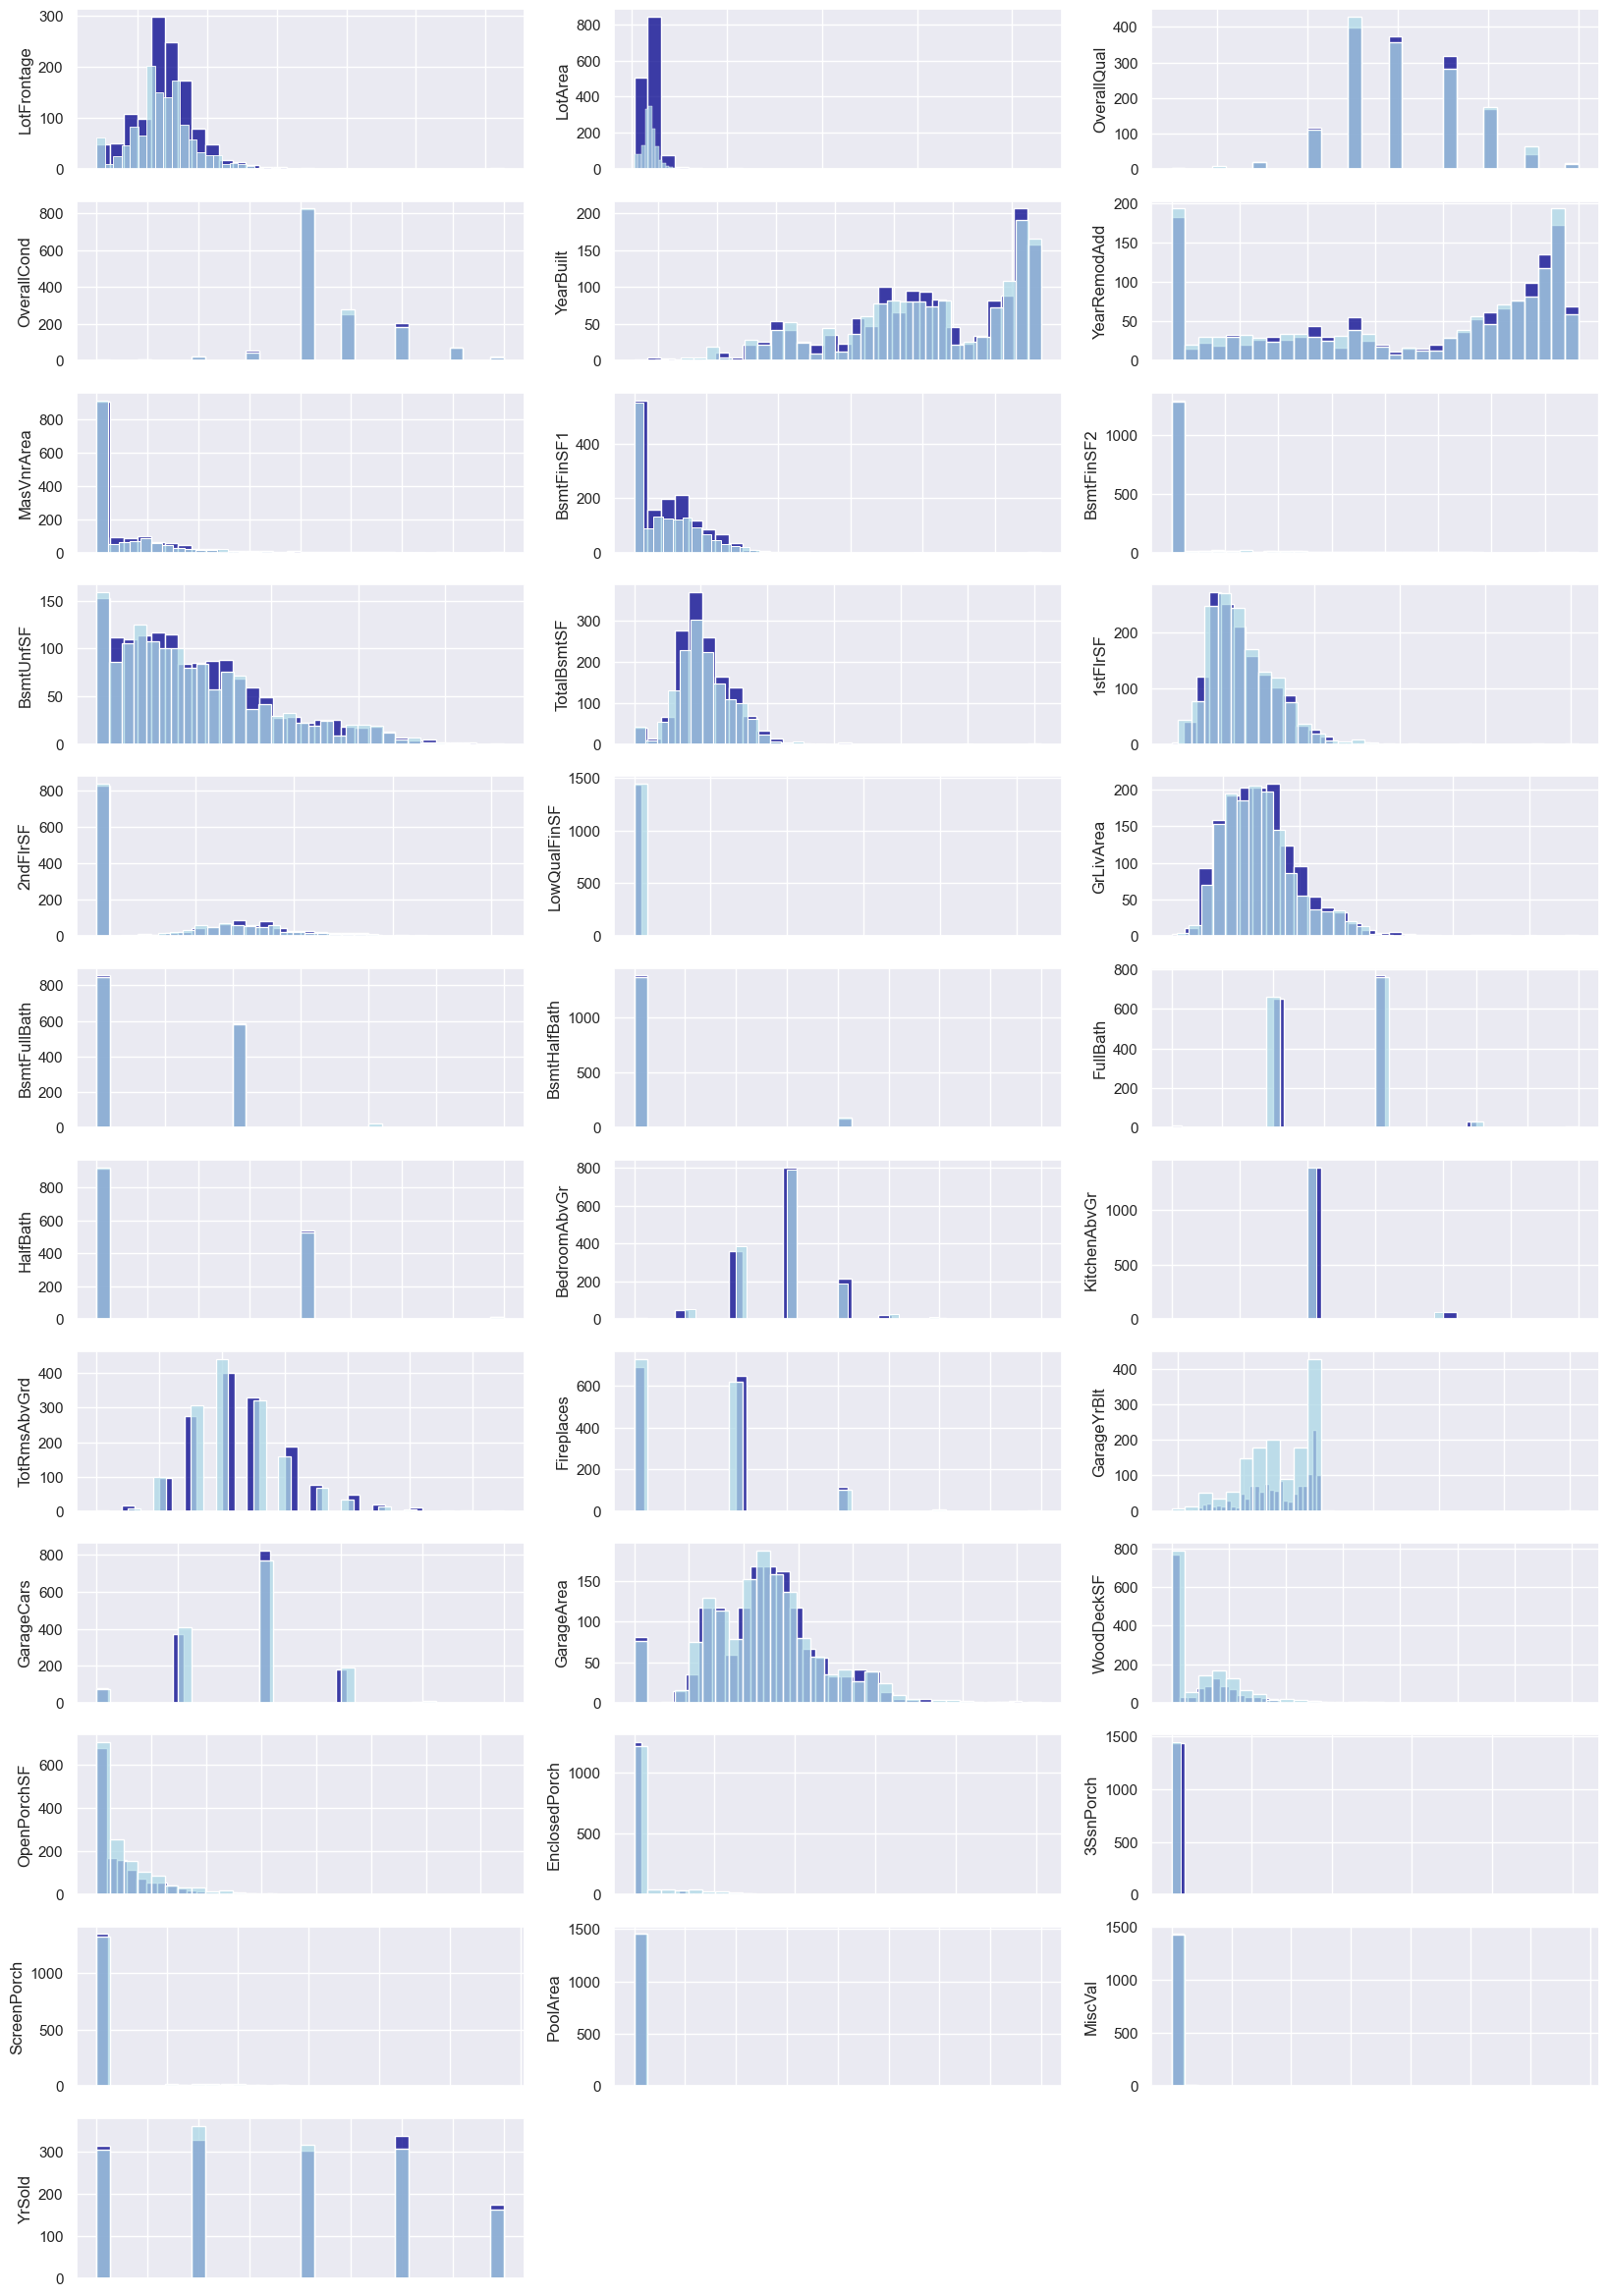

In [356]:
for i, feature in enumerate(num_features):
    plt.subplot(12,3, i*1 + 1)
    plt.ylabel(feature)
    g1 = sns.histplot(data=train1, x=train1[feature], bins=30,  color='darkblue') 
    g2 = sns.histplot(data=test1, x=test1[feature], bins=30, color='lightblue')
    g1.set(xticklabels=[])  
    g1.set(xlabel=None)
    g1.tick_params(bottom=False)  
    g2.set(xticklabels=[])  
    g2.set(xlabel=None)
    g2.tick_params(bottom=False);

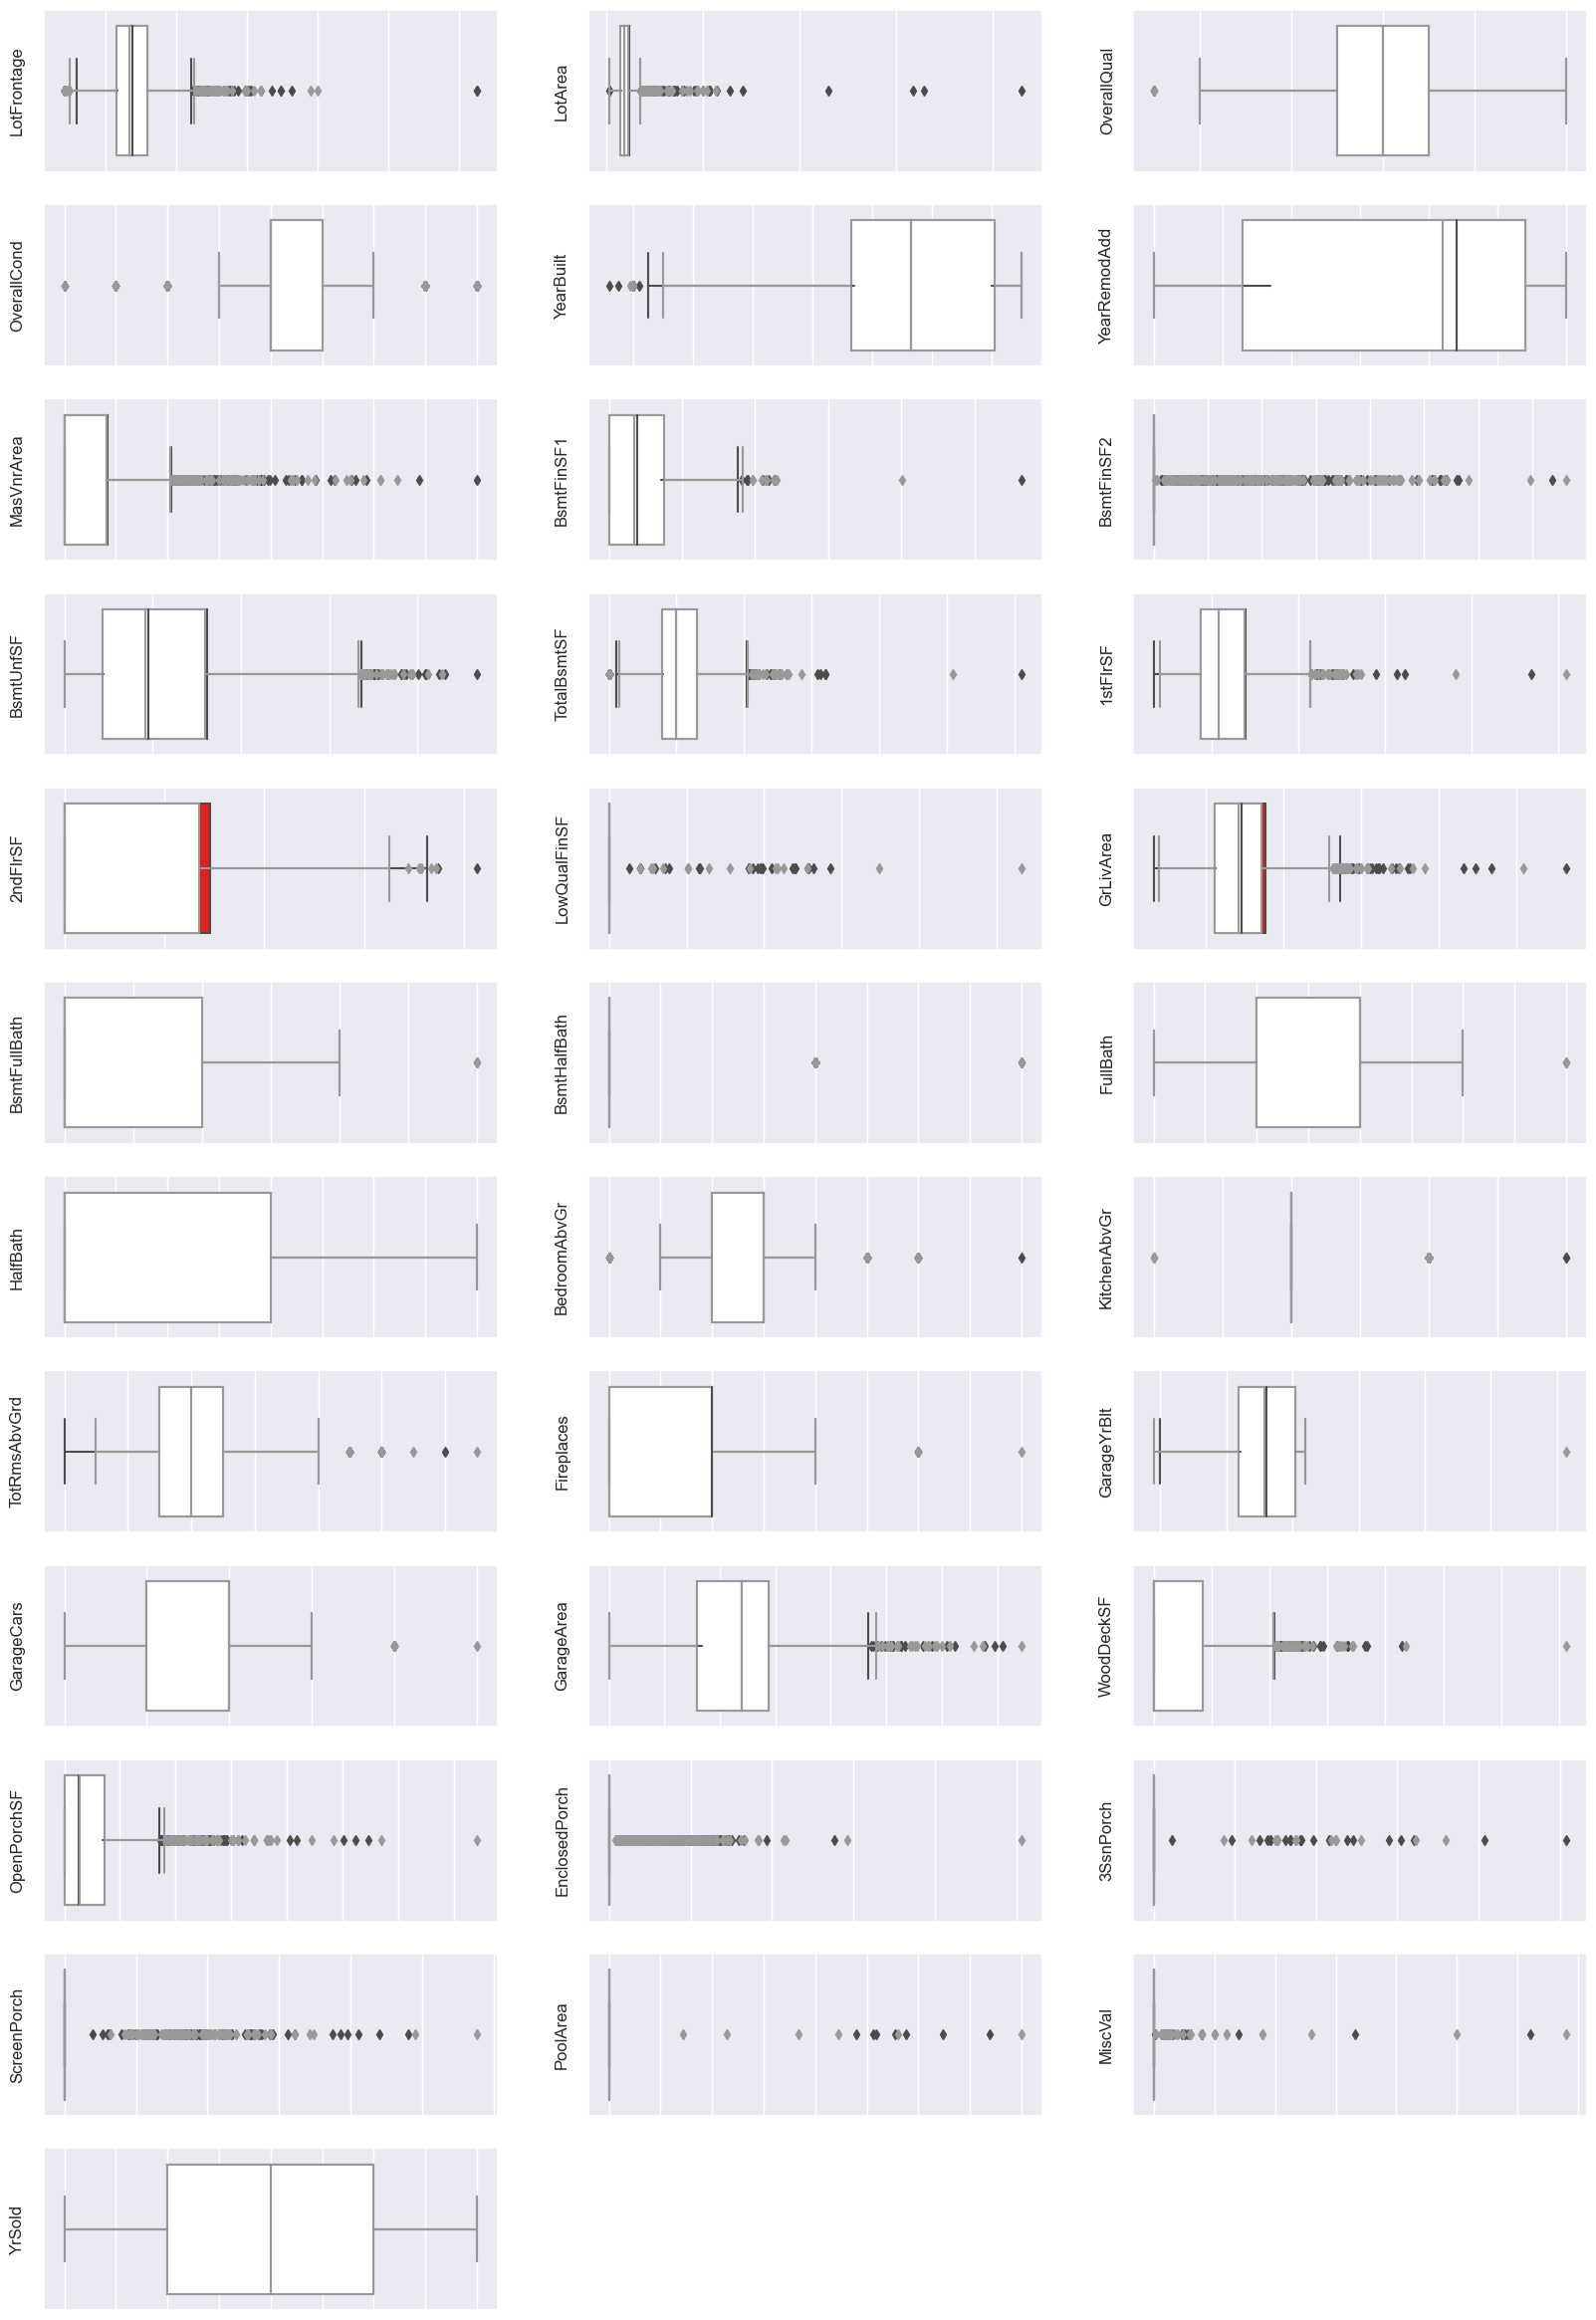

In [357]:
for i, feature in enumerate(num_features):
    plt.subplot(12,3, i*1 + 1)
    plt.ylabel(feature)
    g1 = sns.boxplot(data=train1, x=train1[feature],  color='red') 
    g2 = sns.boxplot(data=test1, x=test1[feature], color='white')
    g1.set(xticklabels=[])  
    g1.set(xlabel=None)
    g1.tick_params(bottom=False)  
    g2.set(xticklabels=[])  
    g2.set(xlabel=None)
    g2.tick_params(bottom=False);

###### Insights:
* 1 - Train and Test sets are so similar (there are no serious difference in features)
* 2 - Features are not normal (there are a lot left-side skew and outlayers, some features has strong-mode in 0 (25%, 50%, 75% percentiles))

Data is needed **numerical feature transformation** (and we will check it for anomalies to find awfully hurmful outlayers)

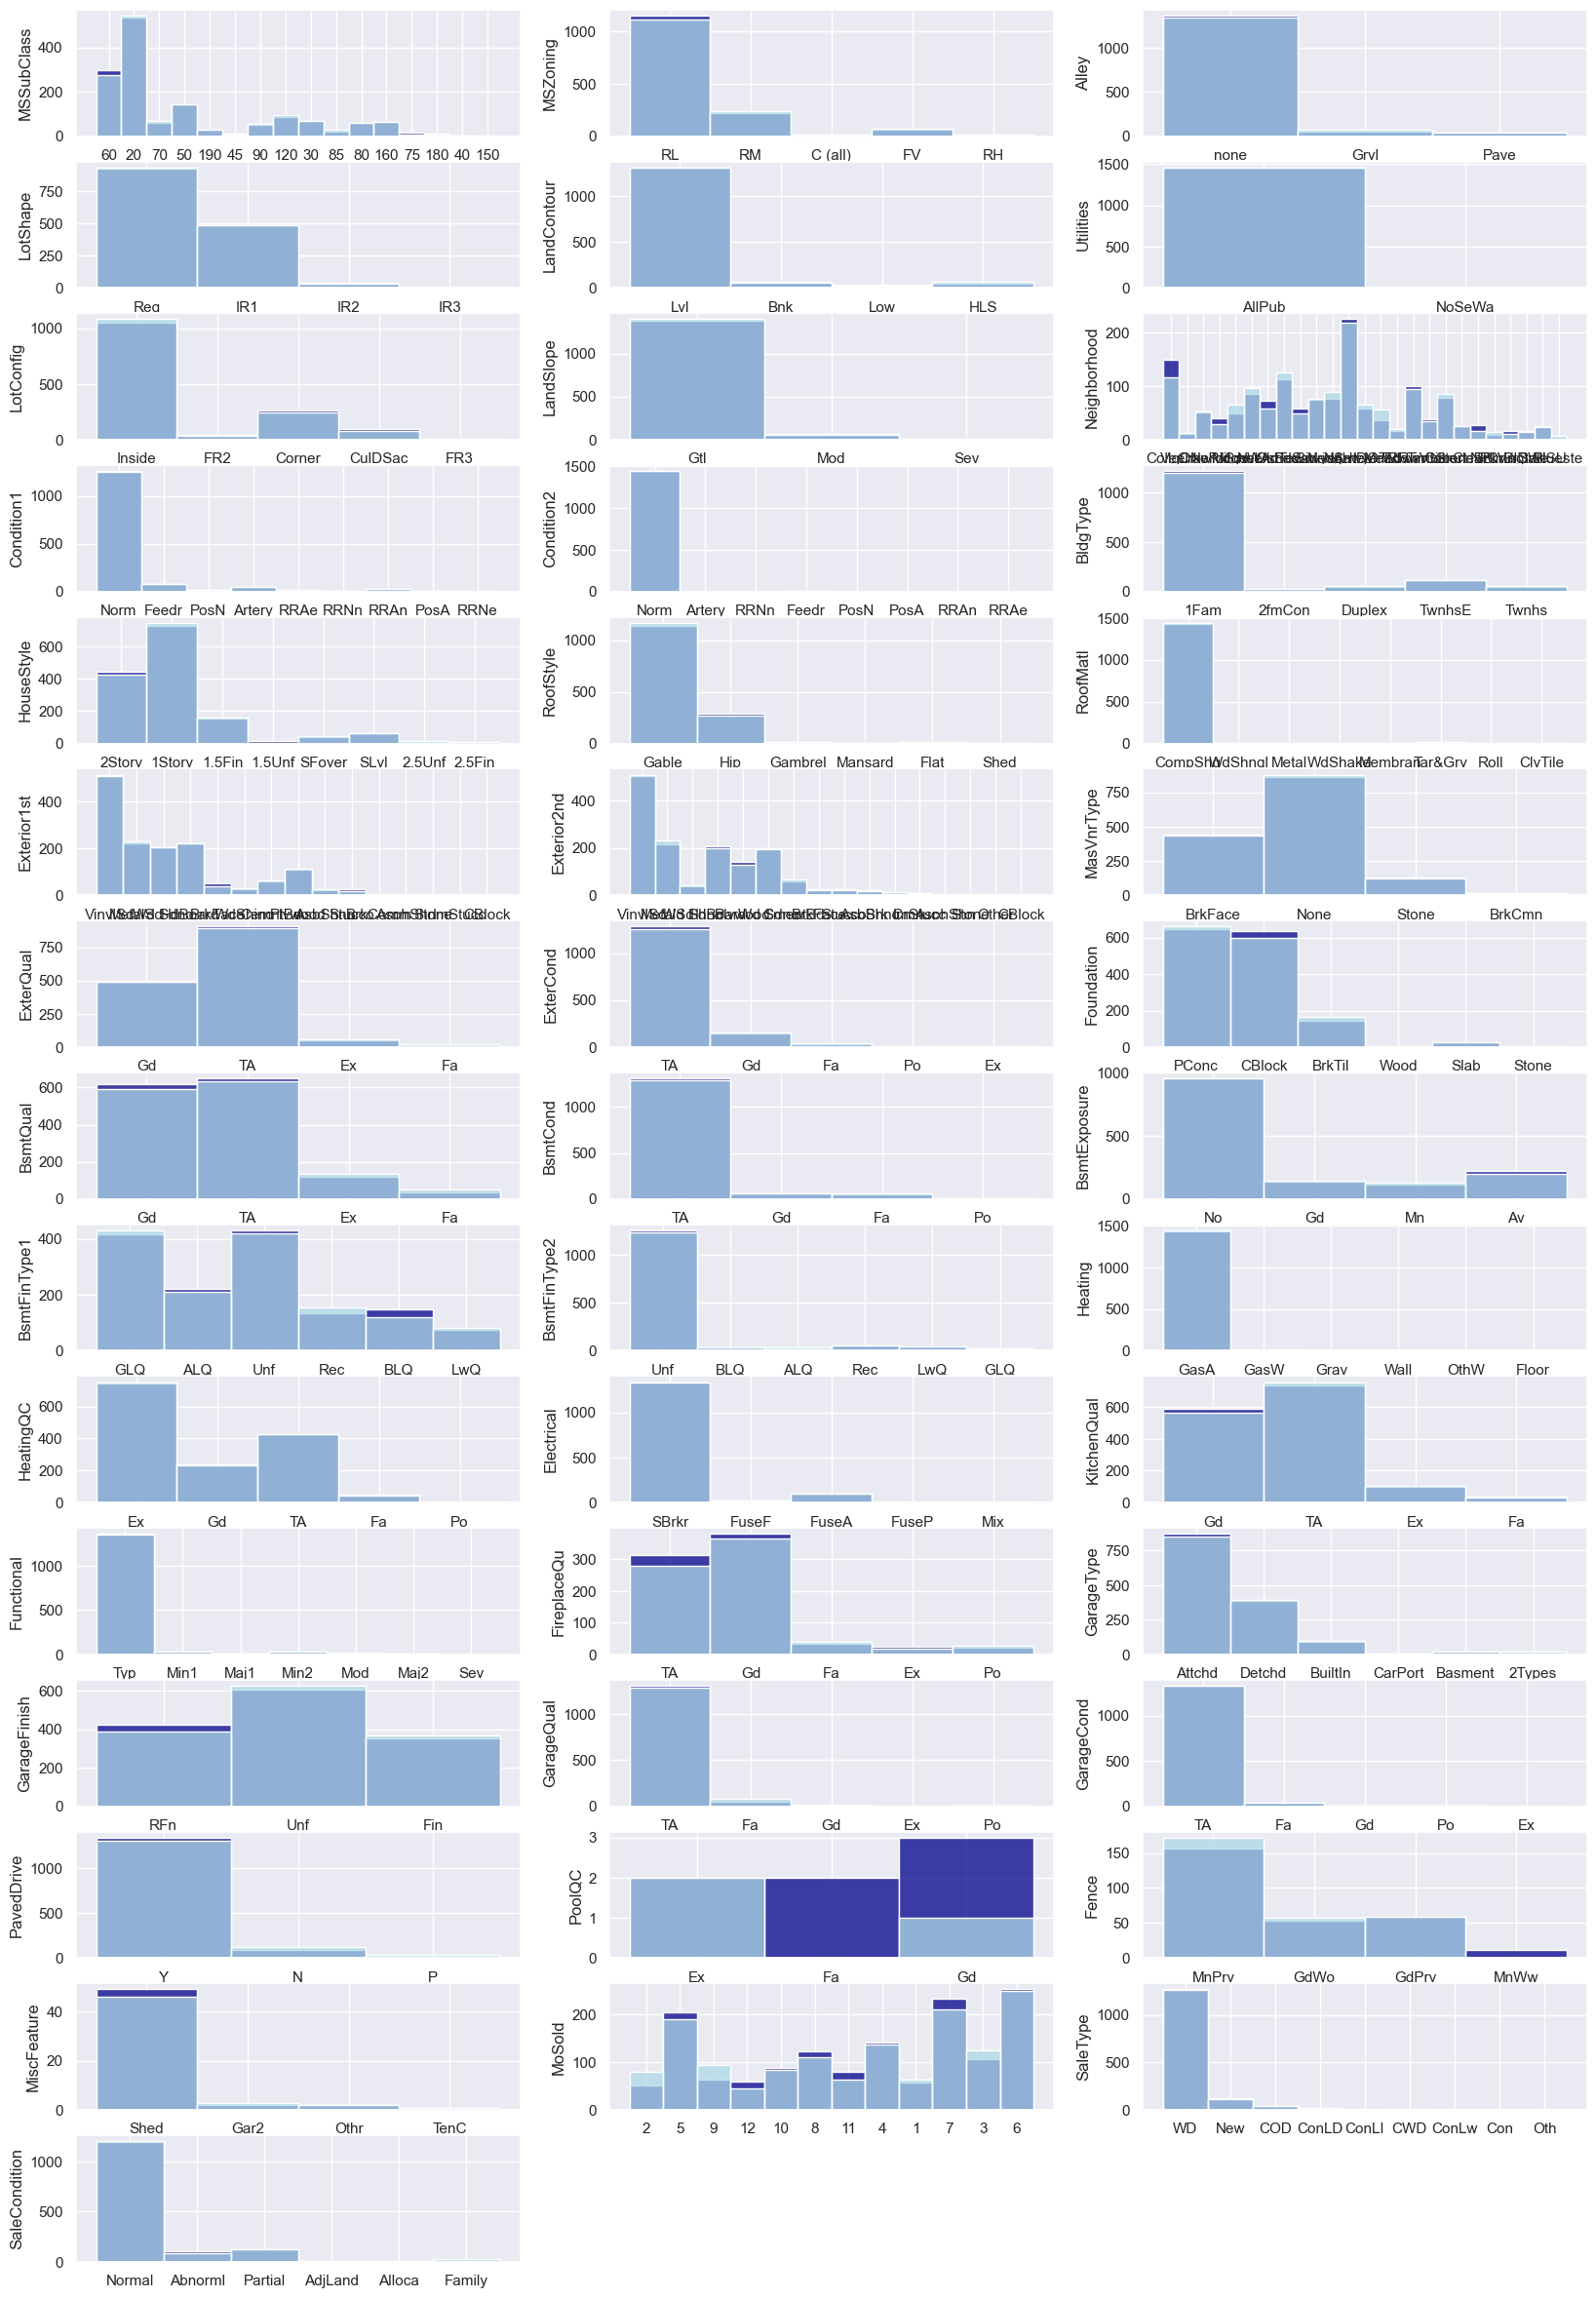

In [358]:
for i, feature in enumerate(cat_features):
    plt.subplot(15,3, i*1 + 1)
    plt.ylabel(feature)
    g1 = sns.histplot(data=train1, x=train1[feature], bins=30, color='darkblue') 
    g2 = sns.histplot(data=test1, x=test1[feature], bins=30, color='lightblue')
    #g1.set(xticklabels=[])  
    g1.set(xlabel=None)
    g1.tick_params(bottom=False)  
    #g2.set(xticklabels=[])  
    g2.set(xlabel=None)
    g2.tick_params(bottom=False);

###### Insights:
* 1 - PoolQC feature has disbalance between train and test sets
* 2 - There are a lot of rare values in categorical features

We will try to transofrm categorical values ("Other" value) and try to fit models without PoolQC

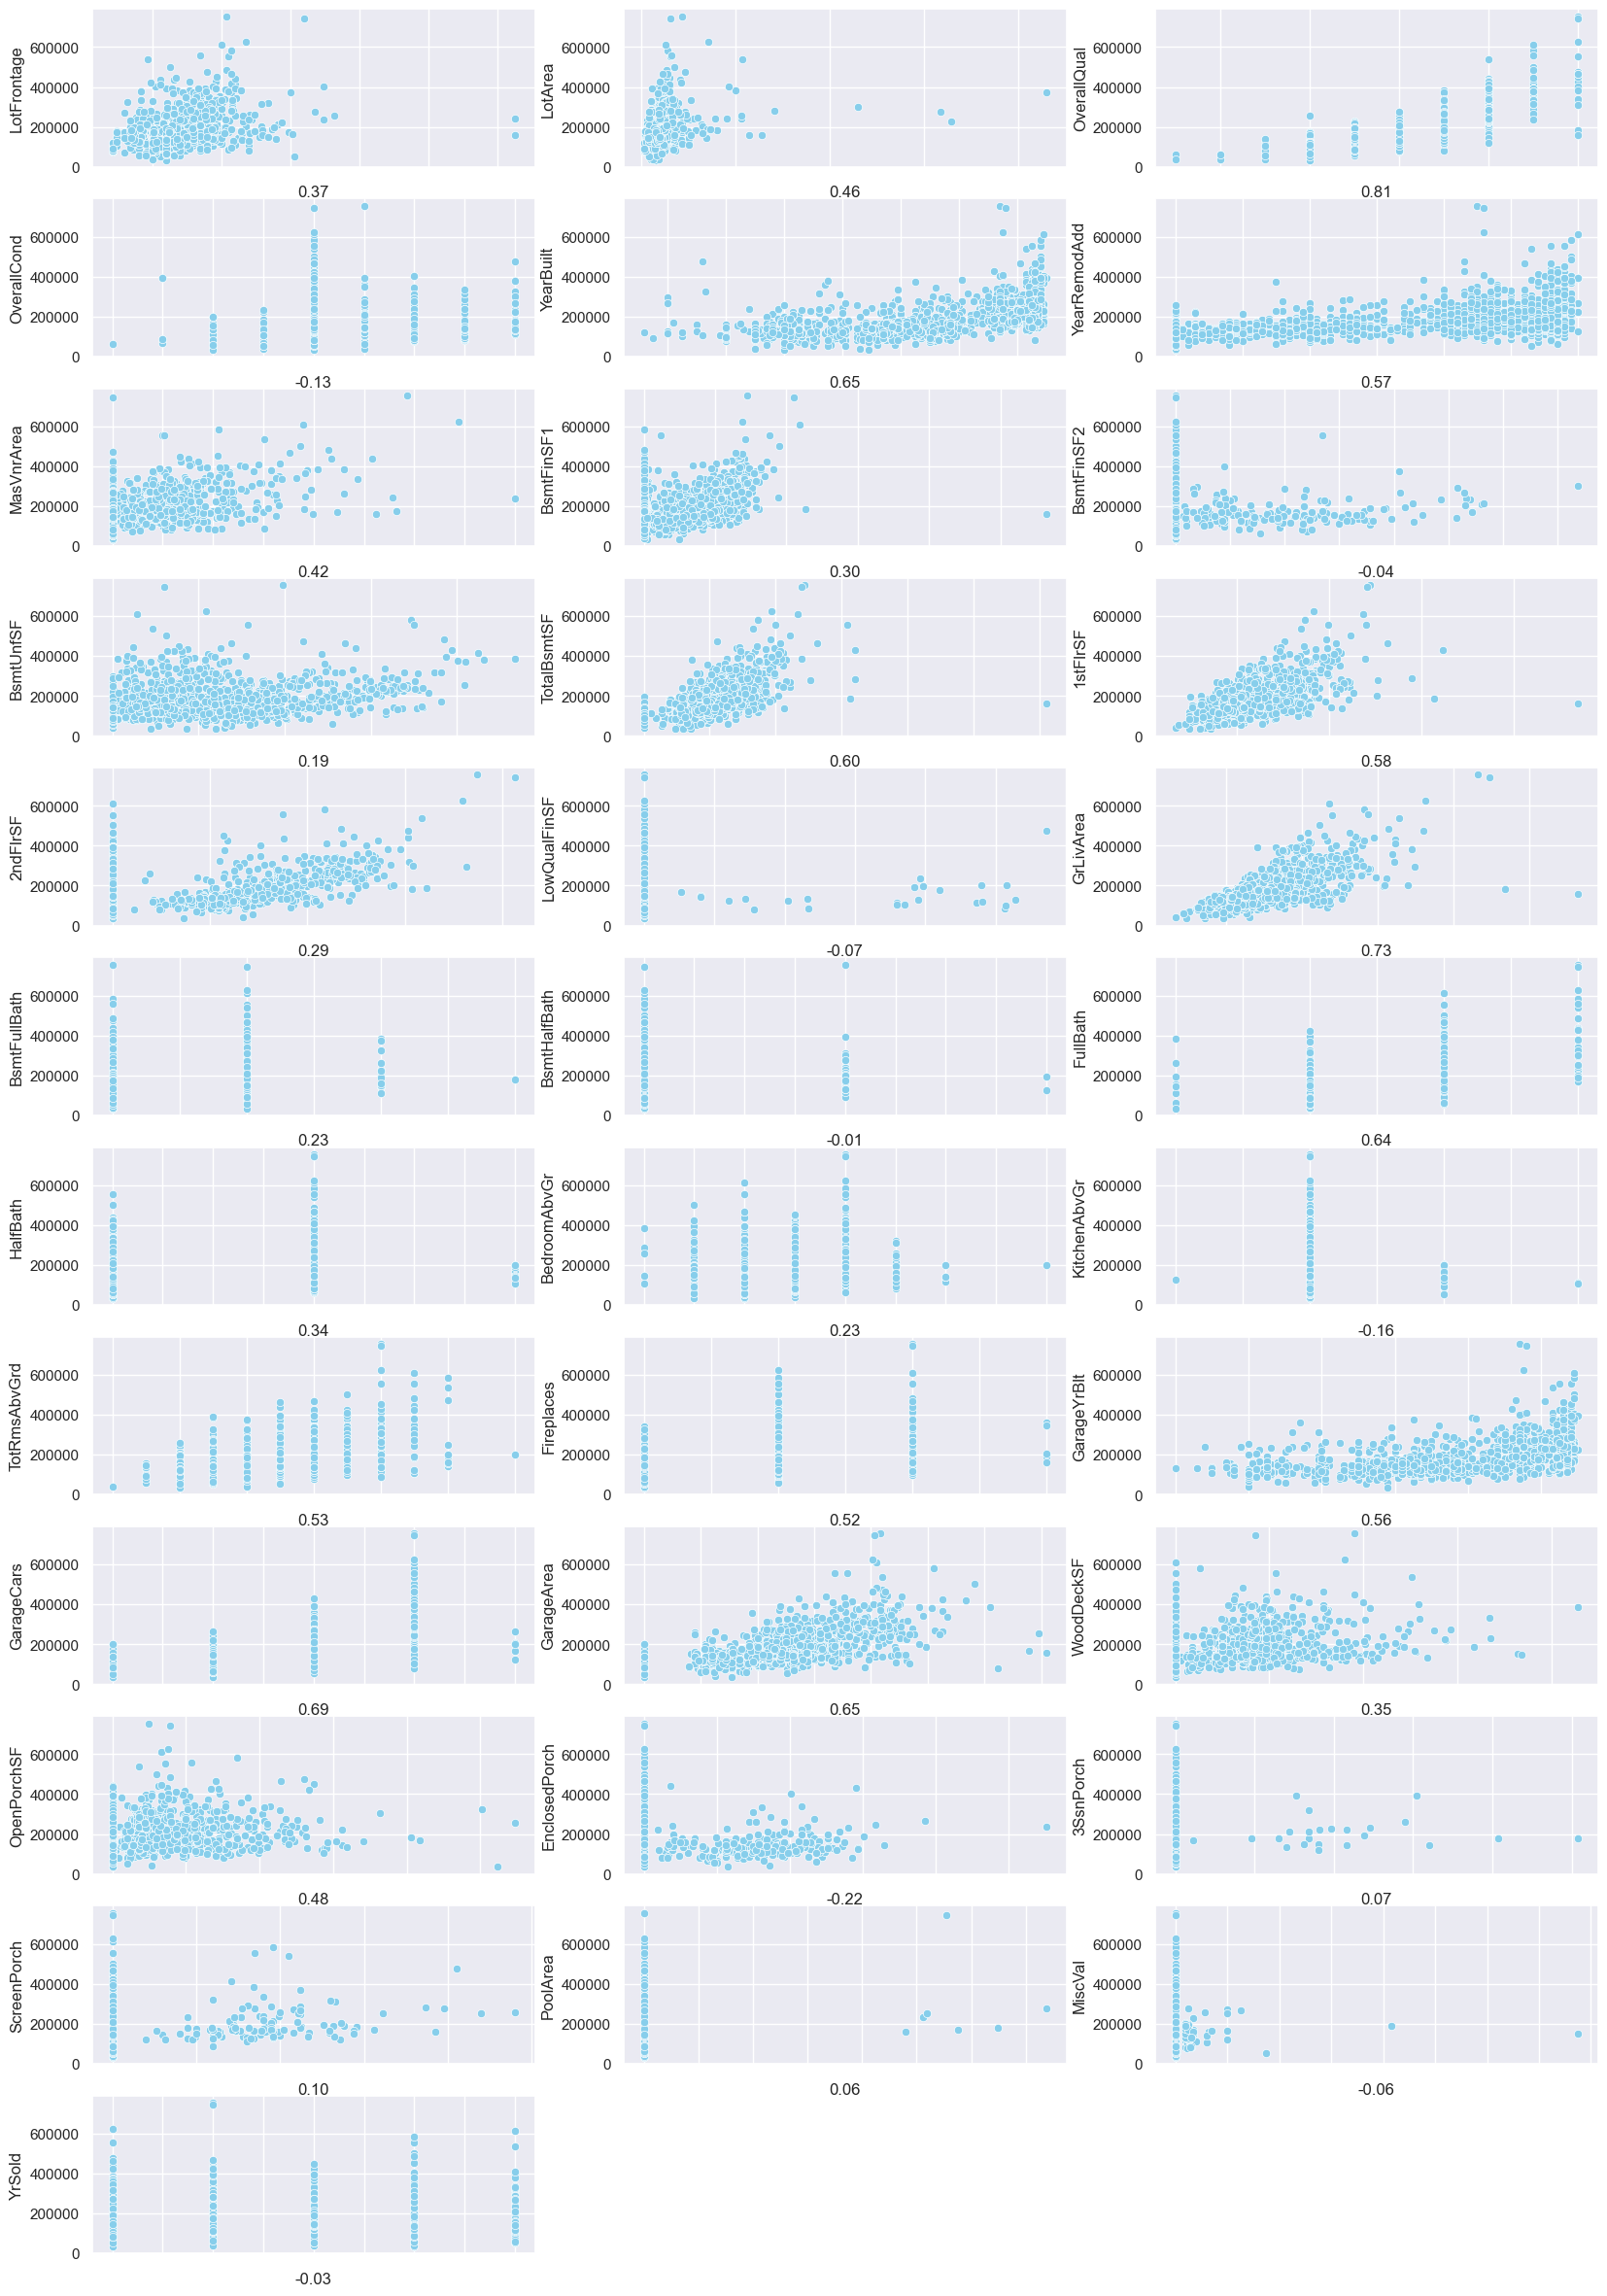

In [367]:
for i, feature in enumerate(num_features):
    plt.subplot(12,3, i*1 + 1)
    plt.ylabel(feature)
    g1 = sns.scatterplot(data=pd.concat([data1, target], axis=1), x=feature, y="SalePrice", color='skyblue') 
    g1.set(xticklabels=[])
    g1.set(xlabel=f"{stats.spearmanr(data1.fillna(data1[feature].median()).loc[train_id,feature], target)[0]:.2f}")
    g1.tick_params(bottom=False) 

###### Insights:
* 1 - Some features have linear dependence with target (OverallQual, GrLivArea, GarageArea) 

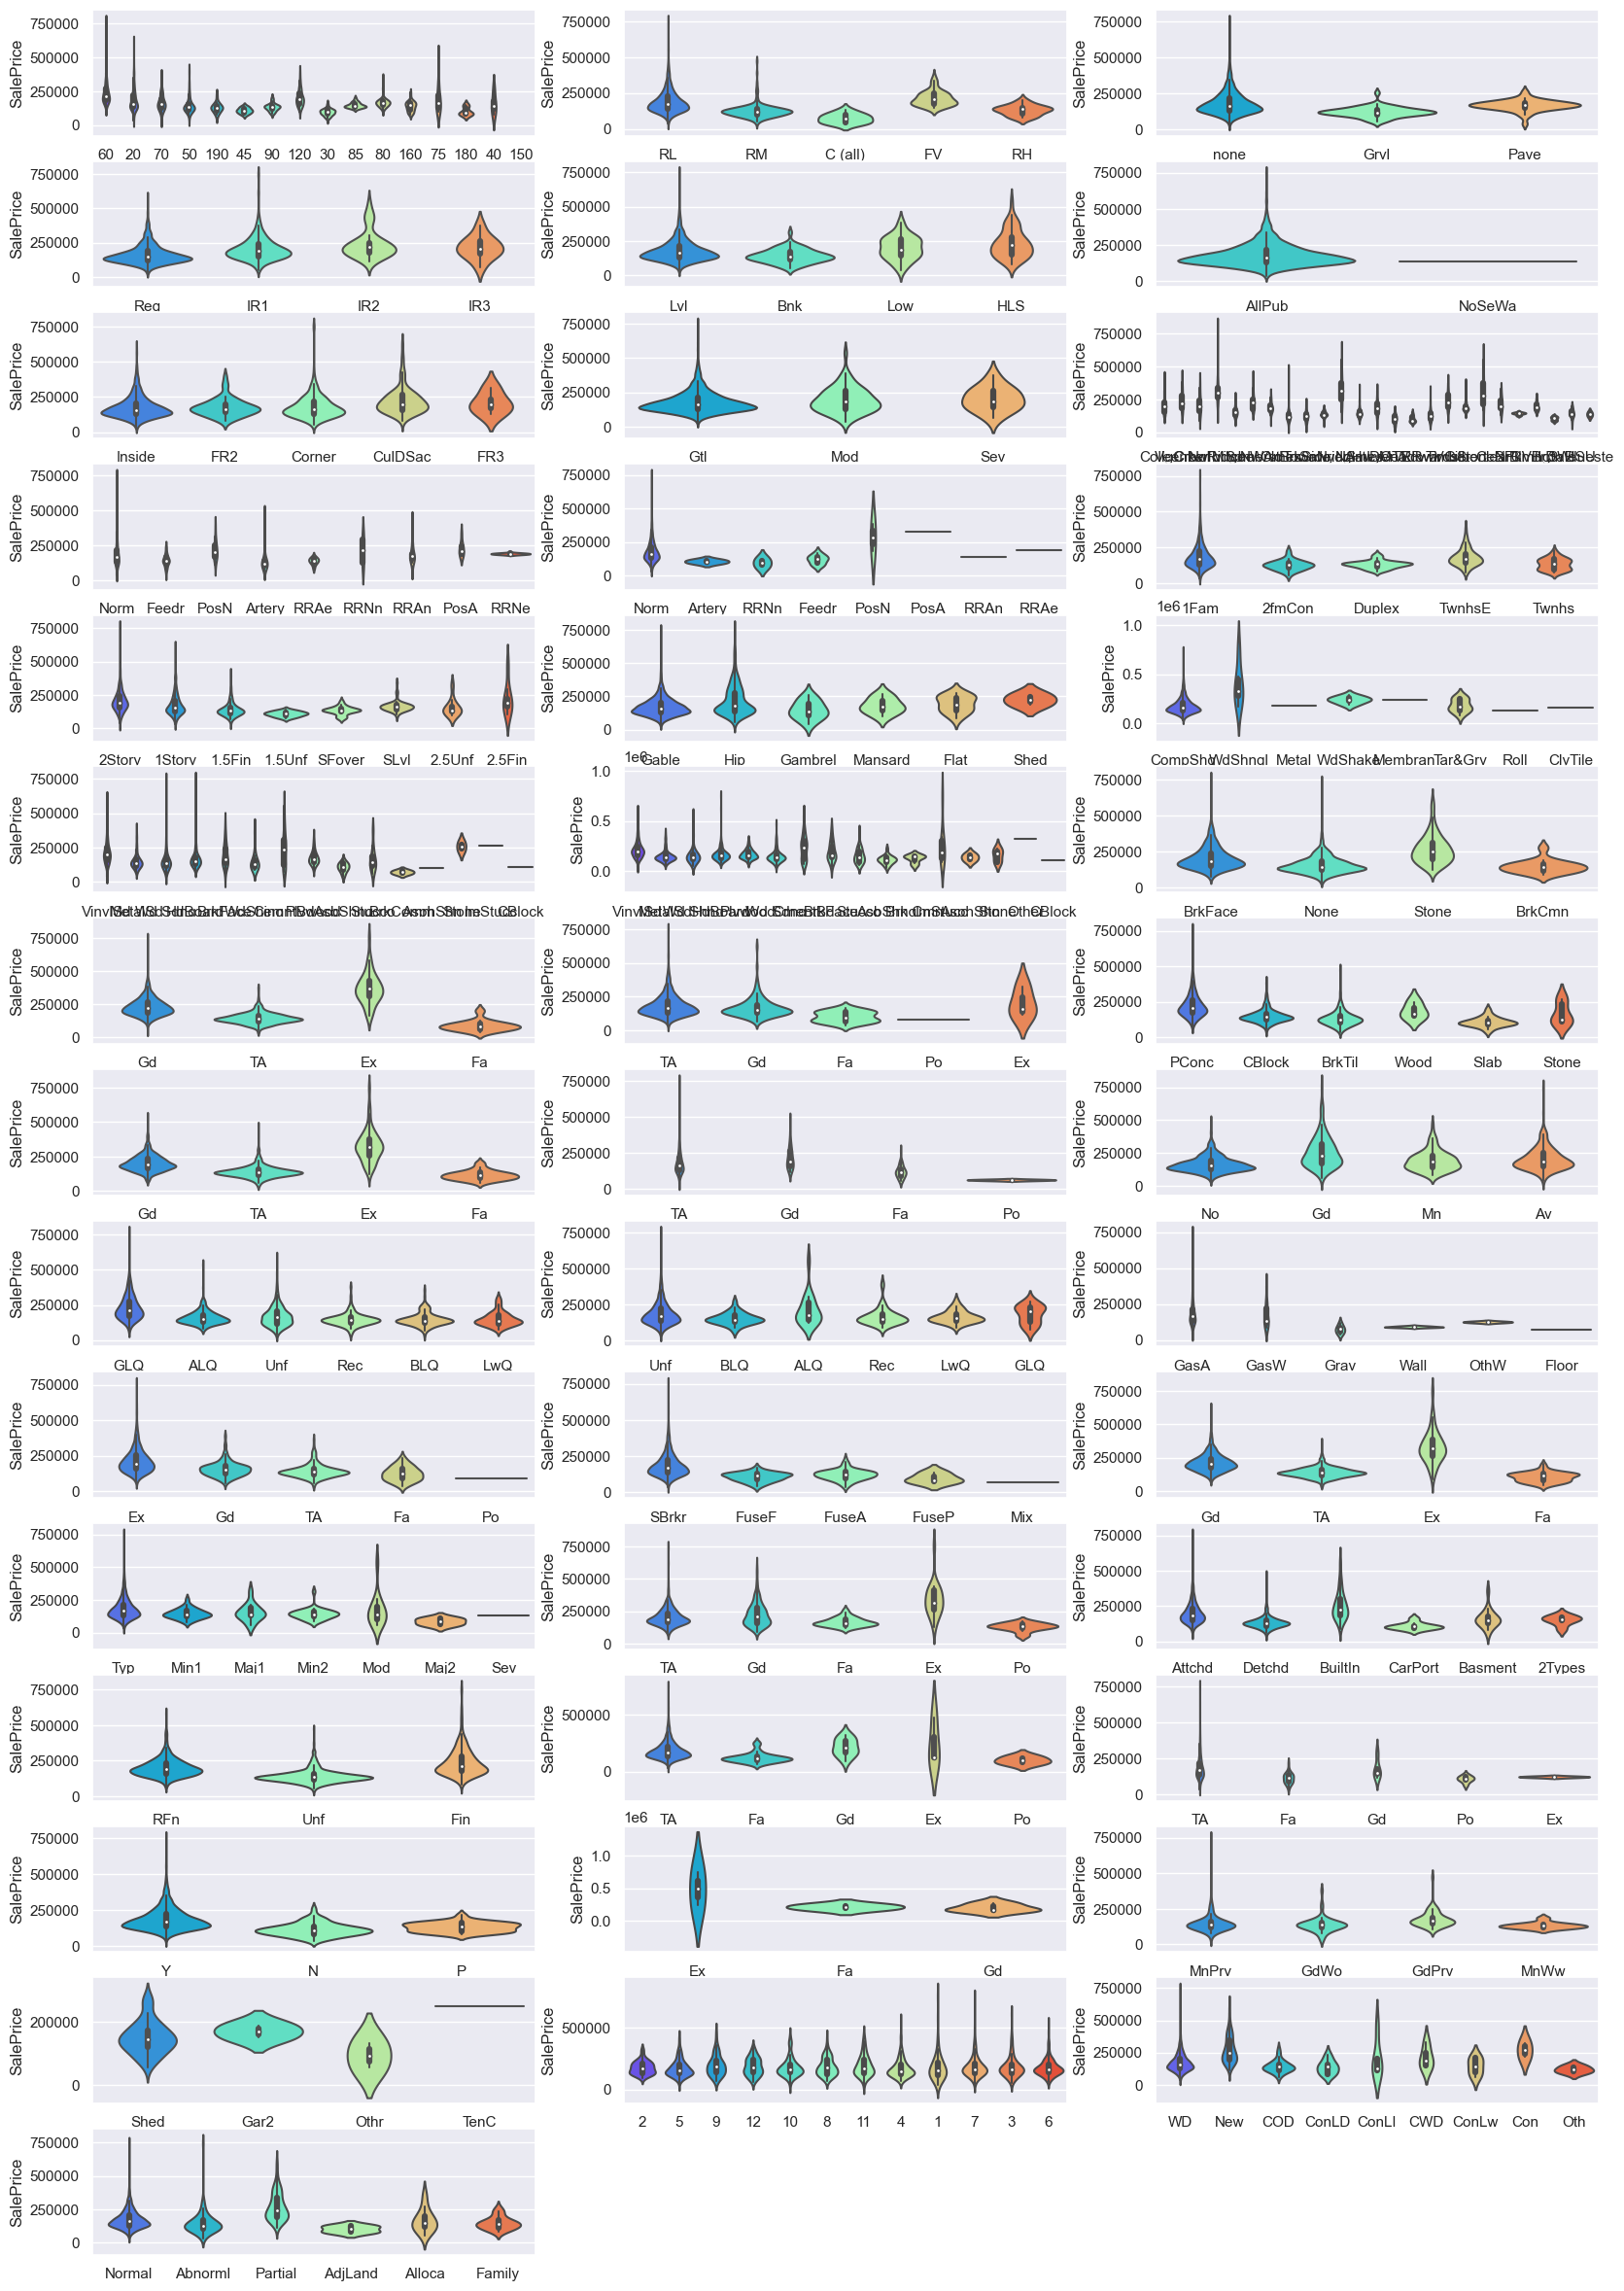

In [21]:
for i, feature in enumerate(cat_features):
    plt.subplot(15,3, i*1 + 1)
    plt.ylabel(feature)
    g1 = sns.violinplot(data=pd.concat([data1, target], axis=1), x=feature, y="SalePrice", palette="rainbow") 
    #g1.set(xticklabels=[])
    g1.set(xlabel=None)
    g1.tick_params(bottom=False) 

### Filling wrong NA values in data

Some NaN features in dataset are not "missing" - they are just bad encoding (mean "None" or "No"). Before continue analysis we will replace it with string value "none"

In [369]:
data2 = data1.copy()

In [370]:
m = data2.isna().sum()/len(data2)
m[m>0].sort_values()[::-1]

PoolQC          0.996574
MiscFeature     0.964029
Fence           0.804385
FireplaceQu     0.486468
LotFrontage     0.166495
GarageYrBlt     0.054471
GarageFinish    0.054471
GarageQual      0.054471
GarageCond      0.054471
GarageType      0.053786
BsmtCond        0.028092
BsmtExposure    0.028092
BsmtQual        0.027749
BsmtFinType2    0.027407
BsmtFinType1    0.027064
MasVnrType      0.008222
MasVnrArea      0.007879
MSZoning        0.001370
BsmtFullBath    0.000685
BsmtHalfBath    0.000685
Utilities       0.000685
Functional      0.000685
Exterior2nd     0.000343
Exterior1st     0.000343
SaleType        0.000343
BsmtFinSF1      0.000343
BsmtFinSF2      0.000343
BsmtUnfSF       0.000343
TotalBsmtSF     0.000343
KitchenQual     0.000343
GarageCars      0.000343
GarageArea      0.000343
Electrical      0.000343
dtype: float64

In [371]:
data2.loc[(data2["PoolQC"].isna())&(data2["PoolArea"]==0), "PoolQC"] = "none"
data2.loc[(data2["MiscFeature"].isna())&(data2["MiscVal"]==0), "MiscFeature"] = "none"
data2.loc[(data2["FireplaceQu"].isna())&(data2["Fireplaces"]==0), "FireplaceQu"] = "none"
data2["Fence"] = data2["Fence"].fillna("none")

In [372]:
garage_features = list(filter(lambda x: "Garage" in x, data2.columns.values))
data2[garage_features]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
Id,,,,,,,
1,Attchd,2003.0,RFn,2.0,548.0,TA,TA
2,Attchd,1976.0,RFn,2.0,460.0,TA,TA
3,Attchd,2001.0,RFn,2.0,608.0,TA,TA
4,Detchd,1998.0,Unf,3.0,642.0,TA,TA
5,Attchd,2000.0,RFn,3.0,836.0,TA,TA
...,...,...,...,...,...,...,...
2915,NaN,NaN,NaN,0.0,0.0,NaN,NaN
2916,CarPort,1970.0,Unf,1.0,286.0,TA,TA
2917,Detchd,1960.0,Unf,2.0,576.0,TA,TA


In [373]:
data2.loc[(data2["GarageType"].isna())&(data2["GarageCond"].isna())&(data2["GarageYrBlt"].isna())
         &(data2["GarageFinish"].isna())&(data2["GarageCars"]==0)&(data2["GarageArea"]==0)&(data2["GarageQual"].isna()),
         ["GarageType", "GarageCond", "GarageFinish", "GarageQual"]] = "none"

In [374]:
bsmt_features = list(filter(lambda x: "Bsmt" in x, data2.columns.values))
data2[bsmt_features]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
Id,,,,,,,,,,,
1,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,1.0,0.0
2,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,0.0,1.0
3,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,1.0,0.0
4,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,1.0,0.0
5,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2915,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,0.0,0.0
2916,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,0.0,0.0
2917,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,1.0,0.0


In [375]:
data2.loc[(data2["BsmtQual"].isna())&(data2["BsmtCond"].isna())&(data2["BsmtExposure"].isna())
          &(data2["BsmtFinType1"].isna())&(data2["BsmtFinType2"].isna())
          &(data2["BsmtFinSF1"]==0)&(data2["BsmtFinSF2"]==0)&(data2["BsmtFullBath"]==0),
          ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]] = "none"

### Finding anomalies

Firstly I removed 1-dim numerical outlayers, but after experiments it is clear that complex models are robust for them, but additional information decrease MSE loss

In [377]:
train1.shape[0]

1460

In [378]:
#indexes_to_delete = []
#indexes_to_delete.append(list(train1.loc[train1["BsmtFullBath"]>2.5].index.values))
#indexes_to_delete.append(list(train1.loc[train1["GarageCars"]>3.5].index.values))
#indexes_to_delete.append(list(train1.loc[train1["TotRmsAbvGrd"]>13].index.values))
#indexes_to_delete.append(list(train1.loc[train1["TotalBsmtSF"]>5000].index.values))
#indexes_to_delete.append(list(train1.loc[train1["BsmtFinSF1"]>5000].index.values))
#indexes_to_delete.append(list(train1.loc[train1["LotFrontage"]>250].index.values))
#indexes_to_delete.append(list(train1.loc[train1["LotArea"]>150000].index.values))
#itd = []
#for i in indexes_to_delete:
#    for j in i:
#        itd.append(j)
#indexes_to_delete = itd

In [379]:
#train1 = train1.drop(indexes_to_delete)
#target = target.drop(indexes_to_delete)

In [380]:
train1.shape[0]

1460

In [381]:
train_id = train1.index.values

In [382]:
data2A = data2.copy()
for col in cat_features:
    data2A[col] = data2[col].fillna(data2[col].mode()[0])
for col in num_features:
    data2A[col] = data2[col].fillna(data2[col].median)

In [383]:
#data2A = data2.fillna({col:data2[col].mode()[0] for col in data2.select_dtypes("O").columns.array})
#data2A = data2.fillna({col:data2[col].median() for col in data2.select_dtypes(np.number).columns.array})

In [384]:
iforest = IsolationForest()
anom_pred = iforest.fit_predict(pd.get_dummies(data2A))

In [385]:
is_anom_pred = np.array(list(map(lambda x: 1 if x == 0 else 0, anom_pred)))

In [386]:
is_anom_pred.sum()

0

isolational forest didn't find any anomalies in out data

### Missing Imputation

In this block we will impute missing values of our data. For categorical imputation we will use random forest, after that we will impute numeric features with iterative_imputer in sklearn (random forest estimator)

In [387]:
data3 = data2.copy()

In [388]:
m = data3.isna().sum()/len(data3)
m = m[m>0].sort_values()
m_num = data3.select_dtypes(np.number).isna().sum()/len(data3)
m_num = m_num[m_num>0].sort_values()
m_cat = data3.select_dtypes("O").isna().sum()/len(data3)
m_cat = m_cat[m_cat>0].sort_values()

In [389]:
num_features_to_impute = m_num.index.values
cat_features_to_impute = m_cat.index.values
features_to_impute = m.index.values

In [390]:
def imputation_rf(data, target, features_to_impute):
    ALL = data.copy()
    TARGET = ALL.copy().loc[~ALL[target].isna(), target]
    ALL = ALL.drop(ALL[features_to_impute], axis=1)
    ALL = pd.get_dummies(ALL)
    X_TRAIN = ALL.loc[~pd.concat([ALL, TARGET], axis=1)[target].isna()]
    X_TEST = ALL.loc[pd.concat([ALL, TARGET], axis=1)[target].isna()]
        
    if target in data.select_dtypes(np.number).columns:
        f = RandomForestRegressor(max_depth=13).fit(X_TRAIN, TARGET)
    else:
        f = RandomForestClassifier(max_depth=13).fit(X_TRAIN, TARGET)
            
    pred = f.predict(X_TEST)
        
    return pred    

In [391]:
for feature in cat_features_to_impute:
    pred = imputation_rf(data3, feature, features_to_impute)
    data3.loc[data3[feature].isna(), feature] = pred
    m = data3.isna().sum()/len(data3)
    m = m[m>0].sort_values()
    features_to_impute = m.index.values

In [393]:
r = RandomForestRegressor(max_depth=14)
data3X = pd.get_dummies(data3)
imputer = IterativeImputer(r, max_iter=5000)
data3X = pd.DataFrame(imputer.fit_transform(data3X), columns=data3X.columns, index=data3.index)

In [394]:
data3[num_features_to_impute] = data3X[num_features_to_impute]

In [395]:
data3.isna().sum().sum()

0

### Feature engineering

In [429]:
data4 = data3.copy()

In [430]:
data4["TotalQual"] = 0.5*data4["OverallCond"] + 0.5*data4["OverallQual"]

#data4["TotalQual"] = data4["TotalQual"].map(str)
data4["OverallCond"] = data4["OverallCond"].map(str)
data4["OverallQual"] = data4["OverallQual"].map(str)

data4["YearDiff"] = (data4["YearRemodAdd"] - data4["YearBuilt"])

data4["TotalBath"] = data4["BsmtFullBath"] + 0.5*data4["BsmtHalfBath"] + data4["FullBath"] + 0.5*data4["HalfBath"]

data4["LivingShare"] = data4["GrLivArea"]/data4["LotArea"]

In [431]:
data4["MoSold_num"] = data4["MoSold"].map(float)
data4["MoSold_sin"] = np.sin(data4["MoSold_num"]/3.82 - 0.262)+1
data4 = data4.drop("MoSold_num", axis=1)

In [432]:
skew_data = pd.DataFrame({"Feature":data4.select_dtypes(np.number).columns, "Skew":np.abs(stats.skew(data4.select_dtypes(np.number)))})
skew_data["IsNeededSkew"] = np.abs(skew_data["Skew"]) > 1
for col in skew_data.loc[skew_data["IsNeededSkew"], "Feature"]:
    if col == "MasVnrArea":
        continue
    prev_skew = float(abs(skew_data.loc[skew_data["Feature"]==col, "Skew"]))
    data4[col] = np.log1p(data4[col])
    temp_skew = np.abs(stats.skew(data4[col]))
    if temp_skew < prev_skew:
        data4["log_"+col] = data4[col]
        data4 = data4.drop(col, axis=1)
        continue
    data4[col] = np.exp(data4[col]) - 1

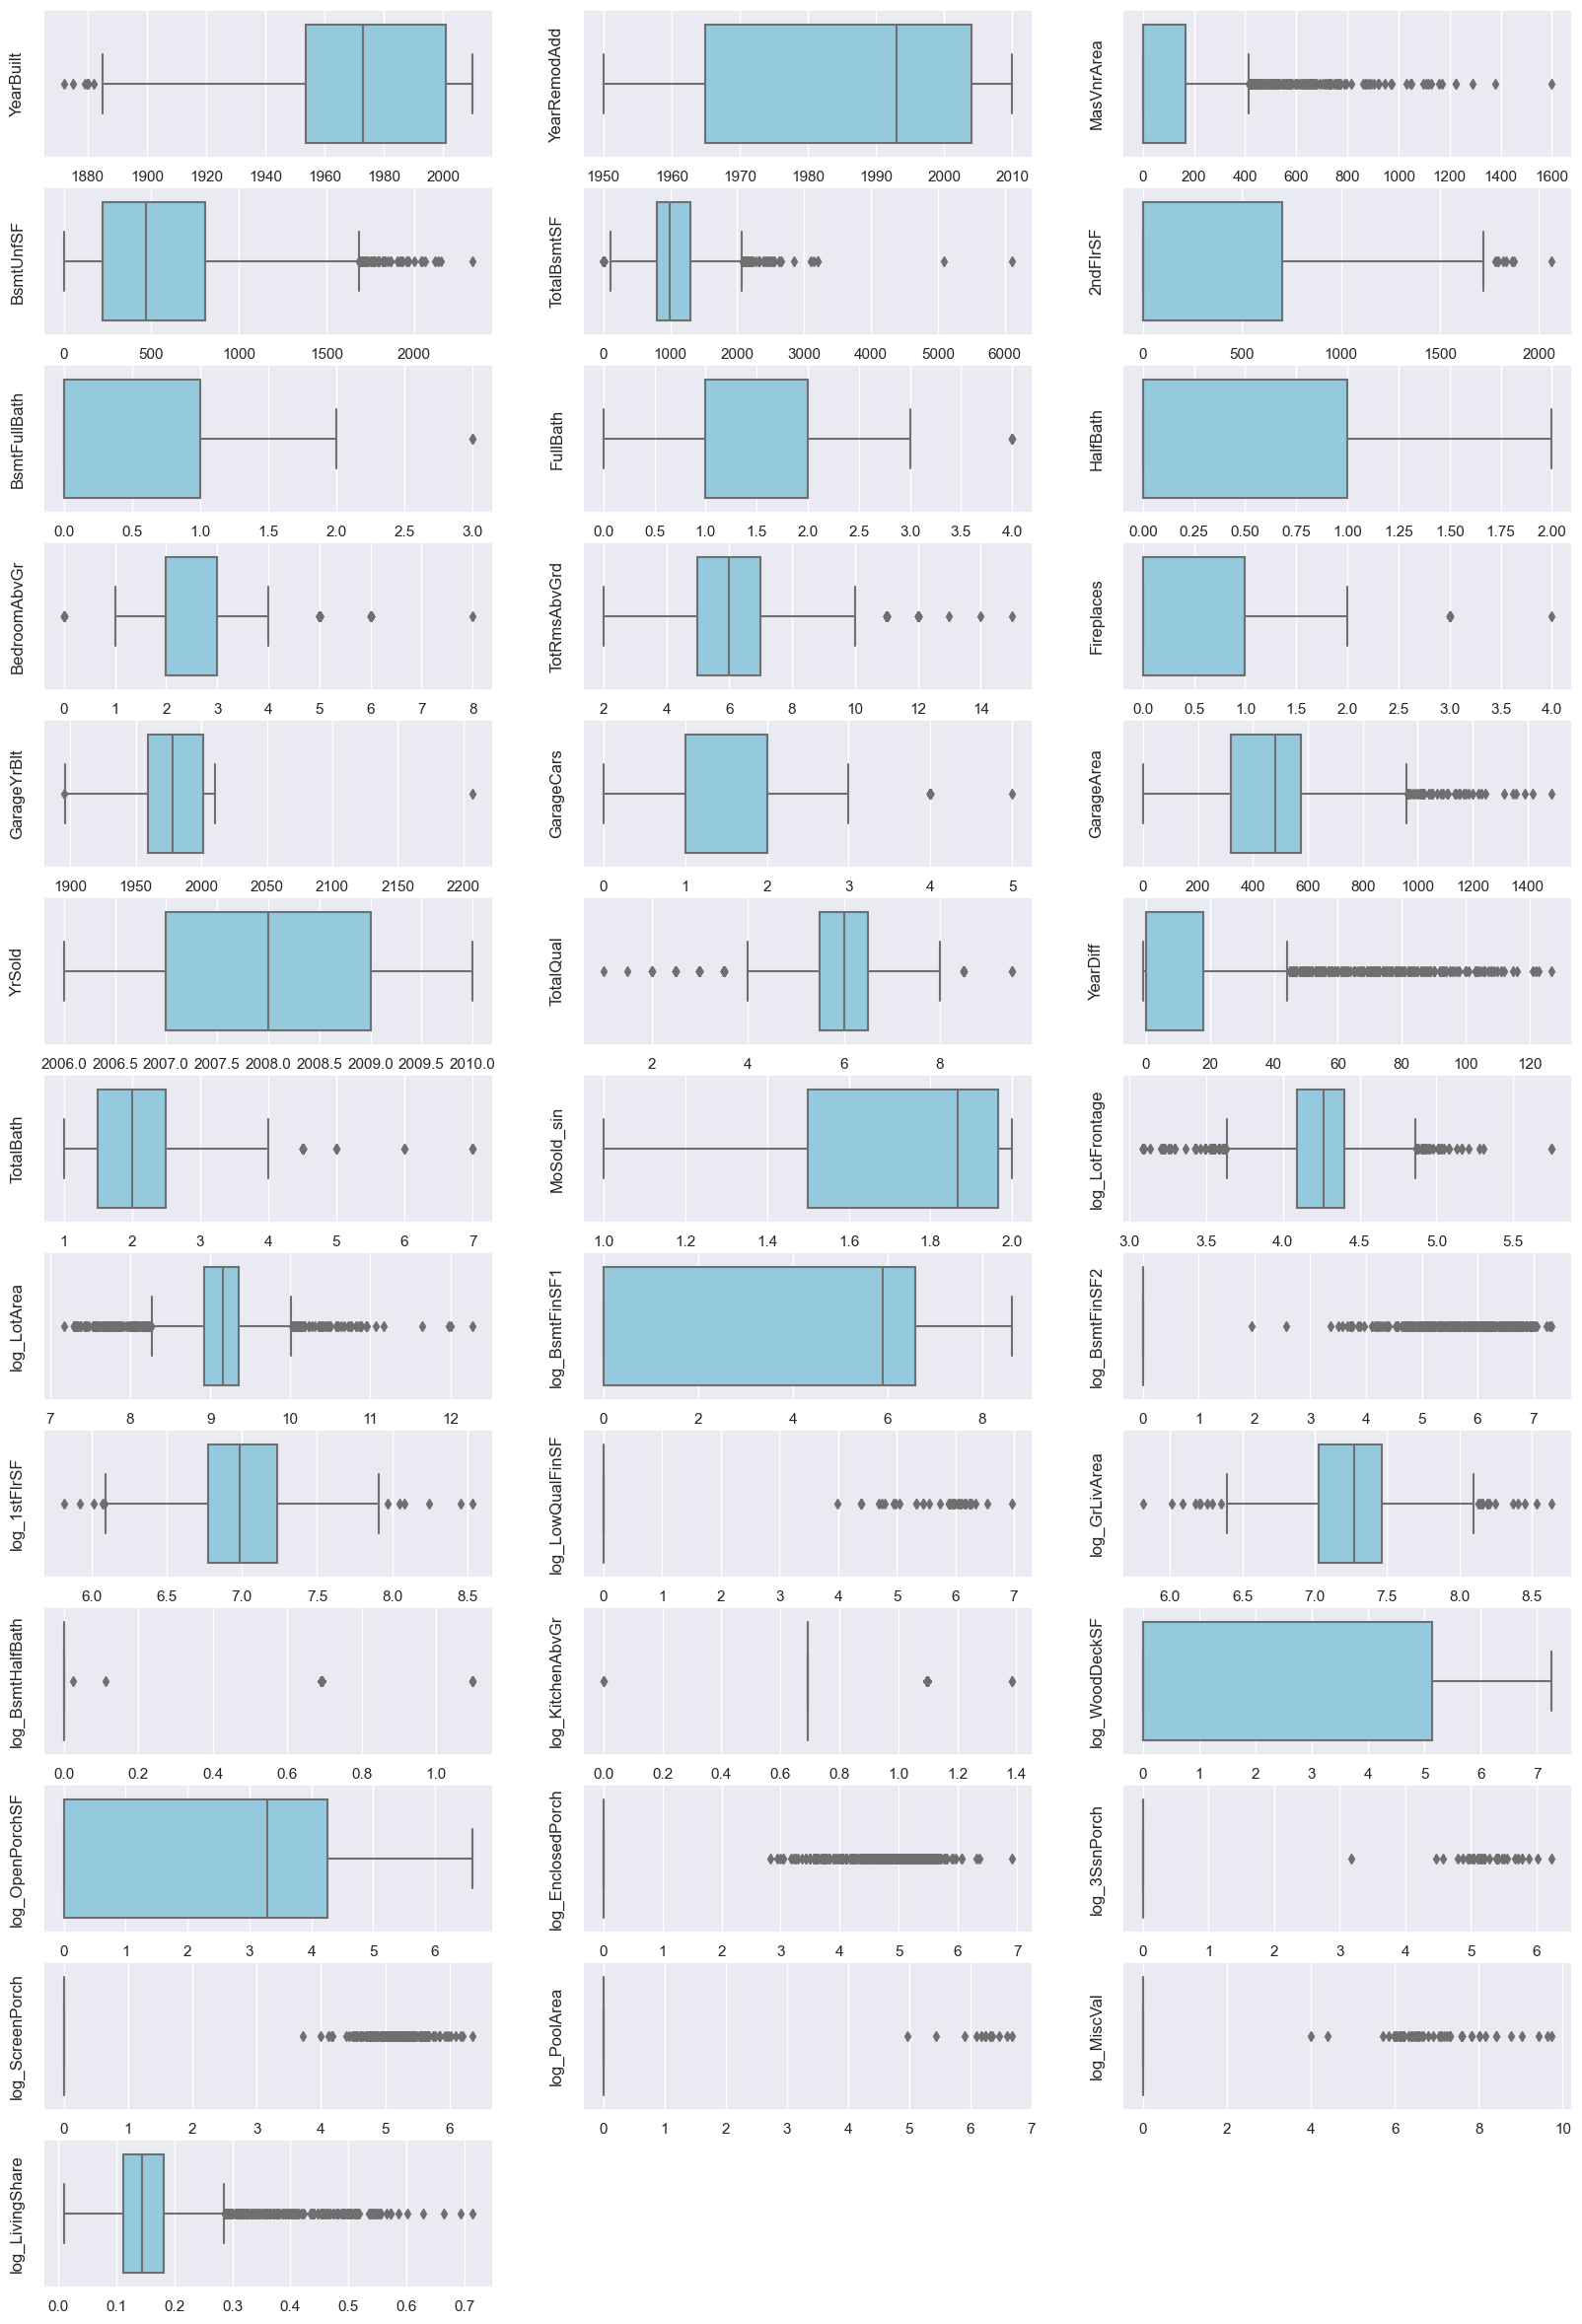

In [433]:
for i, feature in enumerate(data4.select_dtypes(np.number).columns):
    plt.subplot(13,3, i*1 + 1)
    plt.ylabel(feature)
    g1 = sns.boxplot(data=data4, x=feature, color='skyblue') 
    #g1.set(xticklabels=[])
    g1.set(xlabel=None)
    g1.tick_params(bottom=False) 

In [434]:
data4.loc[data4["GarageYrBlt"]>2100, "GarageYrBlt"] = data4["GarageYrBlt"].median()

In [435]:
log_target = np.log(target)

In [437]:
for col in data4.select_dtypes("O"):
    print(col)
    print(data4[col].nunique())
    data4.loc[:, col] = data4[col].mask(data4[col].map(lambda x: data4[col].value_counts(normalize=True)[x])<=0.005, "Otth")
    print(data4[col].nunique())

MSSubClass
15
15
MSZoning
5
5
Alley
3
3
LotShape
4
4
LandContour
4
4
Utilities
2
2
LotConfig
5
5
LandSlope
3
3
Neighborhood
25
25
Condition1
8
8
Condition2
2
2
BldgType
5
5
HouseStyle
8
8
OverallQual
10
9
OverallCond
9
8
RoofStyle
5
5
RoofMatl
3
3
Exterior1st
11
11
Exterior2nd
13
13
MasVnrType
4
4
ExterQual
4
4
ExterCond
4
4
Foundation
5
5
BsmtQual
5
5
BsmtCond
5
5
BsmtExposure
5
5
BsmtFinType1
7
7
BsmtFinType2
7
7
Heating
3
3
HeatingQC
5
5
Electrical
4
4
KitchenQual
4
4
Functional
6
6
FireplaceQu
6
6
GarageType
7
7
GarageFinish
4
4
GarageQual
5
5
GarageCond
5
5
PavedDrive
3
3
PoolQC
2
2
Fence
5
5
MiscFeature
3
3
MoSold
12
12
SaleType
5
5
SaleCondition
6
6


In [438]:
data4.loc[:,data4.select_dtypes("O").columns] = data4.select_dtypes("O").astype("category")
data4.loc[:, data4.select_dtypes(bool).columns] = data4.select_dtypes(bool).astype("category")

##### feature importance

In [418]:
cb = CatBoostRegressor(verbose = 0)
cb.fit(data4.loc[train_id], log_target, cat_features=list(data4.select_dtypes("category").columns.values))

Learning rate set to 0.043466
0:	learn: 0.3876651	total: 164ms	remaining: 2m 43s
1:	learn: 0.3770648	total: 233ms	remaining: 1m 56s
2:	learn: 0.3663664	total: 327ms	remaining: 1m 48s
3:	learn: 0.3564940	total: 419ms	remaining: 1m 44s
4:	learn: 0.3478154	total: 487ms	remaining: 1m 36s
5:	learn: 0.3381711	total: 556ms	remaining: 1m 32s
6:	learn: 0.3299528	total: 630ms	remaining: 1m 29s
7:	learn: 0.3216463	total: 693ms	remaining: 1m 25s
8:	learn: 0.3129987	total: 763ms	remaining: 1m 24s
9:	learn: 0.3051174	total: 853ms	remaining: 1m 24s
10:	learn: 0.2976253	total: 945ms	remaining: 1m 24s
11:	learn: 0.2904859	total: 1.01s	remaining: 1m 23s
12:	learn: 0.2833962	total: 1.07s	remaining: 1m 21s
13:	learn: 0.2767342	total: 1.14s	remaining: 1m 20s
14:	learn: 0.2703276	total: 1.21s	remaining: 1m 19s
15:	learn: 0.2644215	total: 1.28s	remaining: 1m 18s
16:	learn: 0.2586346	total: 1.35s	remaining: 1m 17s
17:	learn: 0.2530962	total: 1.41s	remaining: 1m 17s
18:	learn: 0.2476628	total: 1.48s	remaining:

160:	learn: 0.1057403	total: 11.8s	remaining: 1m 1s
161:	learn: 0.1056009	total: 11.9s	remaining: 1m 1s
162:	learn: 0.1054801	total: 12s	remaining: 1m 1s
163:	learn: 0.1053415	total: 12.1s	remaining: 1m 1s
164:	learn: 0.1051284	total: 12.1s	remaining: 1m 1s
165:	learn: 0.1050326	total: 12.2s	remaining: 1m 1s
166:	learn: 0.1048230	total: 12.3s	remaining: 1m 1s
167:	learn: 0.1047766	total: 12.4s	remaining: 1m 1s
168:	learn: 0.1047488	total: 12.4s	remaining: 1m 1s
169:	learn: 0.1045631	total: 12.5s	remaining: 1m 1s
170:	learn: 0.1043516	total: 12.6s	remaining: 1m 1s
171:	learn: 0.1042940	total: 12.7s	remaining: 1m
172:	learn: 0.1042711	total: 12.7s	remaining: 1m
173:	learn: 0.1041366	total: 12.8s	remaining: 1m
174:	learn: 0.1039792	total: 12.9s	remaining: 1m
175:	learn: 0.1037673	total: 13s	remaining: 1m
176:	learn: 0.1037322	total: 13.1s	remaining: 1m
177:	learn: 0.1035209	total: 13.1s	remaining: 1m
178:	learn: 0.1033874	total: 13.2s	remaining: 1m
179:	learn: 0.1033436	total: 13.3s	remai

321:	learn: 0.0870213	total: 23.1s	remaining: 48.6s
322:	learn: 0.0868676	total: 23.1s	remaining: 48.5s
323:	learn: 0.0867345	total: 23.2s	remaining: 48.4s
324:	learn: 0.0866008	total: 23.3s	remaining: 48.3s
325:	learn: 0.0865202	total: 23.3s	remaining: 48.3s
326:	learn: 0.0864109	total: 23.4s	remaining: 48.2s
327:	learn: 0.0863416	total: 23.5s	remaining: 48.1s
328:	learn: 0.0862933	total: 23.5s	remaining: 48s
329:	learn: 0.0862035	total: 23.6s	remaining: 47.9s
330:	learn: 0.0860735	total: 23.7s	remaining: 47.8s
331:	learn: 0.0858706	total: 23.7s	remaining: 47.7s
332:	learn: 0.0858641	total: 23.8s	remaining: 47.7s
333:	learn: 0.0856815	total: 23.9s	remaining: 47.6s
334:	learn: 0.0856671	total: 23.9s	remaining: 47.5s
335:	learn: 0.0855488	total: 24s	remaining: 47.4s
336:	learn: 0.0855437	total: 24.1s	remaining: 47.3s
337:	learn: 0.0854294	total: 24.1s	remaining: 47.2s
338:	learn: 0.0853167	total: 24.2s	remaining: 47.2s
339:	learn: 0.0852967	total: 24.3s	remaining: 47.1s
340:	learn: 0.08

483:	learn: 0.0757796	total: 34s	remaining: 36.2s
484:	learn: 0.0757644	total: 34.1s	remaining: 36.2s
485:	learn: 0.0756936	total: 34.1s	remaining: 36.1s
486:	learn: 0.0756705	total: 34.2s	remaining: 36s
487:	learn: 0.0756176	total: 34.3s	remaining: 36s
488:	learn: 0.0754980	total: 34.4s	remaining: 35.9s
489:	learn: 0.0754339	total: 34.4s	remaining: 35.8s
490:	learn: 0.0752407	total: 34.5s	remaining: 35.8s
491:	learn: 0.0752203	total: 34.6s	remaining: 35.7s
492:	learn: 0.0751581	total: 34.6s	remaining: 35.6s
493:	learn: 0.0751232	total: 34.7s	remaining: 35.5s
494:	learn: 0.0750535	total: 34.8s	remaining: 35.5s
495:	learn: 0.0750114	total: 34.9s	remaining: 35.4s
496:	learn: 0.0749494	total: 35s	remaining: 35.4s
497:	learn: 0.0749232	total: 35.1s	remaining: 35.3s
498:	learn: 0.0747967	total: 35.1s	remaining: 35.3s
499:	learn: 0.0746709	total: 35.2s	remaining: 35.2s
500:	learn: 0.0746507	total: 35.3s	remaining: 35.1s
501:	learn: 0.0746262	total: 35.3s	remaining: 35.1s
502:	learn: 0.074620

642:	learn: 0.0660939	total: 45.5s	remaining: 25.3s
643:	learn: 0.0660430	total: 45.6s	remaining: 25.2s
644:	learn: 0.0660094	total: 45.7s	remaining: 25.2s
645:	learn: 0.0658896	total: 45.8s	remaining: 25.1s
646:	learn: 0.0658855	total: 45.8s	remaining: 25s
647:	learn: 0.0657932	total: 45.9s	remaining: 24.9s
648:	learn: 0.0657246	total: 46s	remaining: 24.9s
649:	learn: 0.0657058	total: 46s	remaining: 24.8s
650:	learn: 0.0656161	total: 46.1s	remaining: 24.7s
651:	learn: 0.0655897	total: 46.2s	remaining: 24.6s
652:	learn: 0.0655852	total: 46.2s	remaining: 24.6s
653:	learn: 0.0655417	total: 46.3s	remaining: 24.5s
654:	learn: 0.0654984	total: 46.4s	remaining: 24.4s
655:	learn: 0.0654762	total: 46.5s	remaining: 24.4s
656:	learn: 0.0653531	total: 46.6s	remaining: 24.3s
657:	learn: 0.0652365	total: 46.7s	remaining: 24.3s
658:	learn: 0.0652007	total: 46.8s	remaining: 24.2s
659:	learn: 0.0651964	total: 46.8s	remaining: 24.1s
660:	learn: 0.0651869	total: 46.9s	remaining: 24.1s
661:	learn: 0.0650

802:	learn: 0.0592082	total: 56.6s	remaining: 13.9s
803:	learn: 0.0591517	total: 56.7s	remaining: 13.8s
804:	learn: 0.0591157	total: 56.8s	remaining: 13.8s
805:	learn: 0.0590792	total: 56.8s	remaining: 13.7s
806:	learn: 0.0589633	total: 56.9s	remaining: 13.6s
807:	learn: 0.0589447	total: 57s	remaining: 13.5s
808:	learn: 0.0589346	total: 57s	remaining: 13.5s
809:	learn: 0.0589227	total: 57.1s	remaining: 13.4s
810:	learn: 0.0588630	total: 57.2s	remaining: 13.3s
811:	learn: 0.0588557	total: 57.2s	remaining: 13.3s
812:	learn: 0.0588321	total: 57.3s	remaining: 13.2s
813:	learn: 0.0588284	total: 57.4s	remaining: 13.1s
814:	learn: 0.0588254	total: 57.5s	remaining: 13s
815:	learn: 0.0587960	total: 57.5s	remaining: 13s
816:	learn: 0.0587658	total: 57.6s	remaining: 12.9s
817:	learn: 0.0587269	total: 57.6s	remaining: 12.8s
818:	learn: 0.0587105	total: 57.7s	remaining: 12.8s
819:	learn: 0.0586343	total: 57.8s	remaining: 12.7s
820:	learn: 0.0585608	total: 57.9s	remaining: 12.6s
821:	learn: 0.058501

964:	learn: 0.0526255	total: 1m 8s	remaining: 2.47s
965:	learn: 0.0525793	total: 1m 8s	remaining: 2.4s
966:	learn: 0.0525423	total: 1m 8s	remaining: 2.33s
967:	learn: 0.0524602	total: 1m 8s	remaining: 2.26s
968:	learn: 0.0524563	total: 1m 8s	remaining: 2.19s
969:	learn: 0.0524497	total: 1m 8s	remaining: 2.12s
970:	learn: 0.0524046	total: 1m 8s	remaining: 2.05s
971:	learn: 0.0522981	total: 1m 8s	remaining: 1.98s
972:	learn: 0.0522937	total: 1m 8s	remaining: 1.91s
973:	learn: 0.0522772	total: 1m 8s	remaining: 1.83s
974:	learn: 0.0522678	total: 1m 8s	remaining: 1.76s
975:	learn: 0.0522399	total: 1m 8s	remaining: 1.69s
976:	learn: 0.0521879	total: 1m 8s	remaining: 1.62s
977:	learn: 0.0521789	total: 1m 8s	remaining: 1.55s
978:	learn: 0.0521273	total: 1m 9s	remaining: 1.48s
979:	learn: 0.0520695	total: 1m 9s	remaining: 1.41s
980:	learn: 0.0520273	total: 1m 9s	remaining: 1.34s
981:	learn: 0.0520213	total: 1m 9s	remaining: 1.27s
982:	learn: 0.0519896	total: 1m 9s	remaining: 1.2s
983:	learn: 0.

In [424]:
fi = pd.DataFrame({"Feature":cb.feature_names_, "Importance":cb.feature_importances_}).sort_values("Importance")[::-1]

<AxesSubplot:xlabel='Importance', ylabel='Feature'>

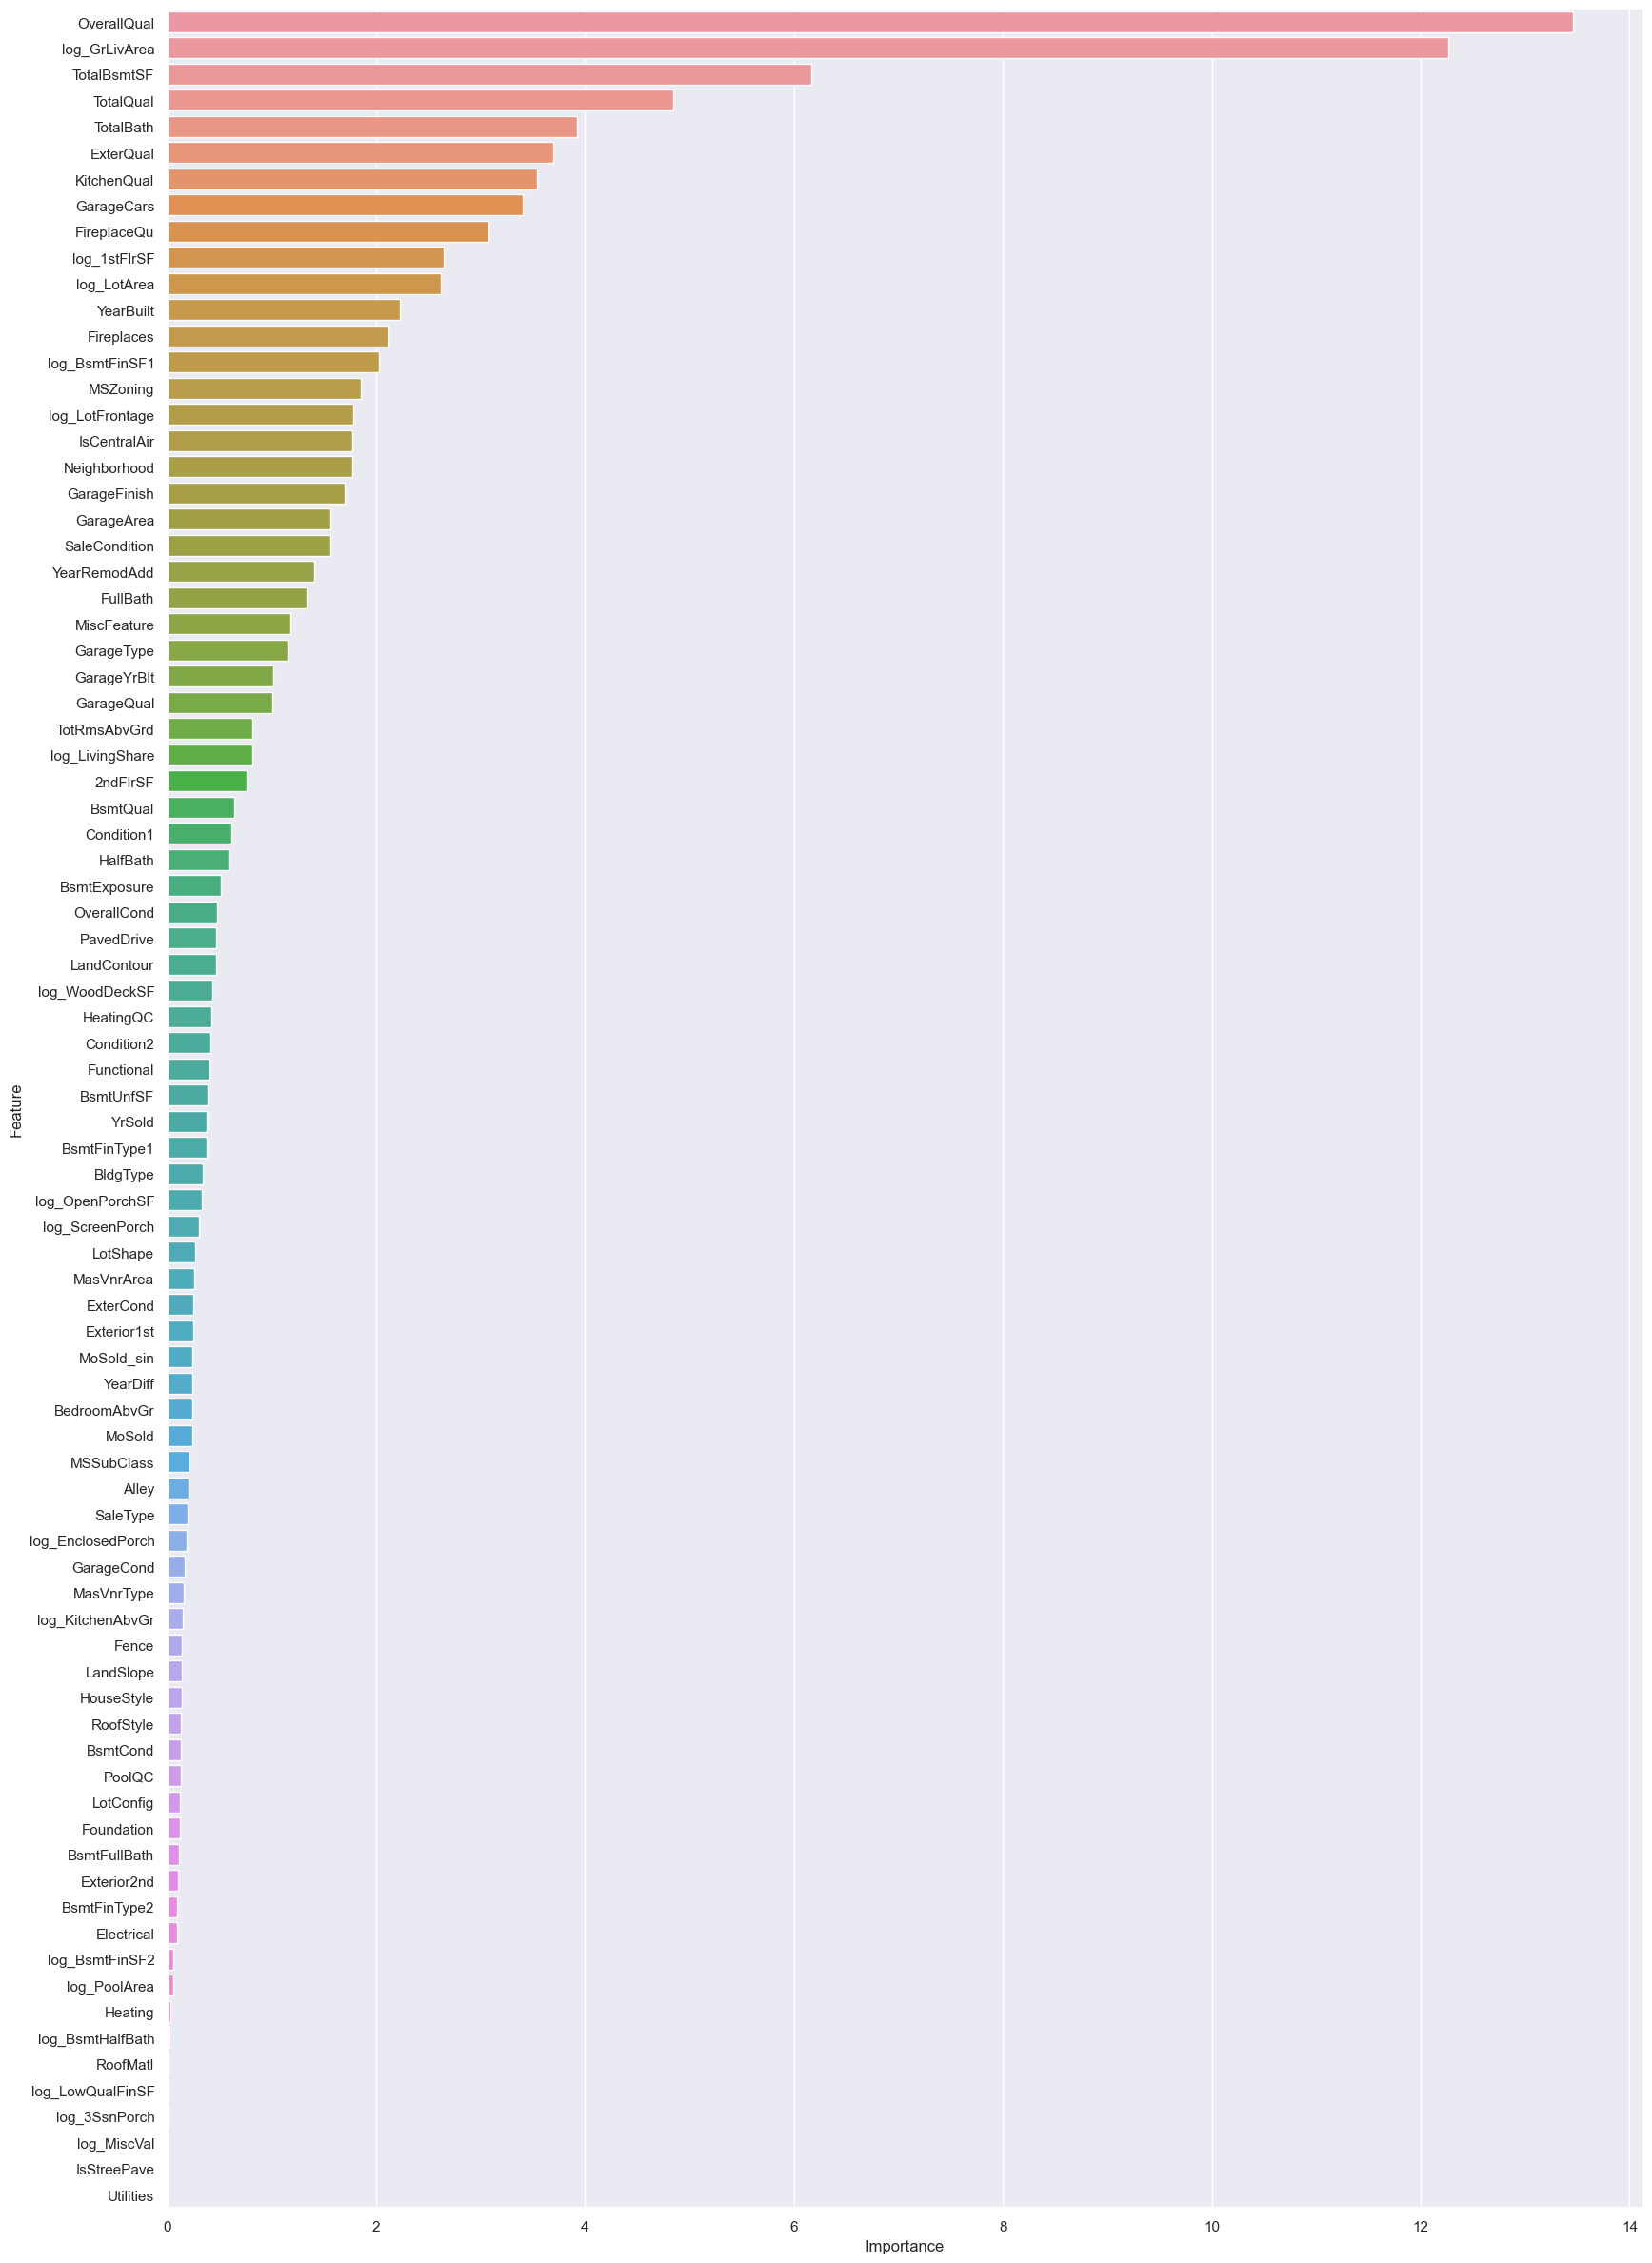

In [426]:
sns.barplot(data=fi, y="Feature", x="Importance")

In [479]:
len(fi)

84

In [480]:
data4 = data4.drop(["Utilities", "IsStreePave", "log_MiscVal", "log_3SsnPorch", "log_LowQualFinSF"], axis=1)

In [481]:
data4.shape[1]

79

### Modeling

In [482]:
seed = 42
kf = KFold(10, random_state=seed)

In [483]:
num_data4 = StandardScaler().fit_transform(data4.select_dtypes(np.number))
X = data4.copy()
X[data4.select_dtypes(np.number).columns] = num_data4

In [484]:
X.loc[:,X.select_dtypes("O").columns] = X.select_dtypes("O").astype("category")
X.loc[:, X.select_dtypes(bool).columns] = X.select_dtypes(bool).astype("category")

In [485]:
X_D = pd.get_dummies(X)

In [486]:
X_TRAIN = X.loc[train_id]
X_train, X_val, y_train, y_val = train_test_split(X_TRAIN, log_target, test_size = 0.25, random_state=seed)
X_TEST = X.loc[test_id]

In [76]:
regression.setup(pd.concat([pd.get_dummies(X_TRAIN), log_target], axis=1), target="SalePrice")
regression.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0784,0.0142,0.1169,0.9137,0.0091,0.0066,2.9370
lightgbm,Light Gradient Boosting Machine,0.0868,0.0165,0.1268,0.8994,0.0098,0.0073,0.2480
gbr,Gradient Boosting Regressor,0.0863,0.0169,0.1279,0.8970,0.0099,0.0072,0.2020
rf,Random Forest Regressor,0.0891,0.0180,0.1325,0.8902,0.0103,0.0074,0.5050
br,Bayesian Ridge,0.0817,0.0187,0.1298,0.8853,0.0100,0.0068,0.0330
xgboost,Extreme Gradient Boosting,0.0960,0.0202,0.1402,0.8757,0.0109,0.0080,0.4630
ridge,Ridge Regression,0.0864,0.0202,0.1359,0.8749,0.0104,0.0072,0.0070
omp,Orthogonal Matching Pursuit,0.0866,0.0210,0.1365,0.8702,0.0105,0.0073,0.0080
et,Extra Trees Regressor,0.0964,0.0212,0.1444,0.8700,0.0112,0.0080,0.5540
huber,Huber Regressor,0.0952,0.0239,0.1530,0.8503,0.0119,0.0080,0.1740


In [77]:
regression.setup(pd.concat([X_TRAIN, log_target], axis=1), target="SalePrice")
regression.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.0751,0.0120,0.1080,0.9245,0.0084,0.0063,0.0380
omp,Orthogonal Matching Pursuit,0.0799,0.0128,0.1118,0.9190,0.0087,0.0067,0.0200
ridge,Ridge Regression,0.0800,0.0136,0.1155,0.9133,0.0090,0.0067,0.0190
catboost,CatBoost Regressor,0.0810,0.0142,0.1174,0.9113,0.0091,0.0068,3.1200
gbr,Gradient Boosting Regressor,0.0865,0.0156,0.1235,0.9020,0.0096,0.0072,0.2290
lightgbm,Light Gradient Boosting Machine,0.0886,0.0163,0.1260,0.8972,0.0098,0.0074,0.1860
rf,Random Forest Regressor,0.0944,0.0192,0.1369,0.8796,0.0106,0.0079,0.4410
huber,Huber Regressor,0.0917,0.0193,0.1378,0.8727,0.0108,0.0077,0.1850
xgboost,Extreme Gradient Boosting,0.1041,0.0214,0.1453,0.8623,0.0113,0.0087,0.4430
et,Extra Trees Regressor,0.1038,0.0233,0.1506,0.8537,0.0116,0.0087,0.6030


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

In [487]:
MODELS = {"br":BayesianRidge(), "RF":RandomForestRegressor(), "omp":OrthogonalMatchingPursuit(),
         "ridge":Ridge(), "cb":CatBoostRegressor(verbose=0), "lgbm":LGBMRegressor(), "xgb":XGBRegressor()}
RESULTS = pd.DataFrame()

In [445]:
for name, model in MODELS.items():
    pred = np.sqrt(-cross_val_score(model, X_D.loc[train_id], log_target, cv=kf, scoring="neg_mean_squared_error"))
    mean = pred.mean()
    std = pred.std()
    RESULTS.loc["cv_mean", name] = mean
    RESULTS.loc["cv_std", name] = std
RESULTS

,br,RF,omp,ridge,cb,lgbm,xgb
cv_mean,0.126556,0.136486,0.130304,0.131862,0.115594,0.127353,0.135382
cv_std,0.027293,0.017781,0.028245,0.025172,0.017642,0.016332,0.016810


In [488]:
def br_obj(trial):
    params = {
    "n_iter" : trial.suggest_int("n_iter",50,600),
    "tol" : trial.suggest_loguniform("tol", 1e-7, 10.0),
    "alpha_1" : trial.suggest_loguniform("alpha_1", 1e-7,10.0),
    "alpha_2" : trial.suggest_loguniform("alpha_2", 1e-7,10.0),
    "lambda_1" : trial.suggest_loguniform("lambda_1", 1e-7,10.0),
    "lambda_2" : trial.suggest_loguniform("lambda_2", 1e-7,10.0)
    }
    
    model = BayesianRidge(**params)
    
    cv_score = np.sqrt(-cross_val_score(model, X_D.loc[train_id], log_target, cv=kf, scoring="neg_mean_squared_error"))
    
    return np.mean(cv_score)
    
br_study = optuna.create_study(direction="minimize")

[I 2022-12-11 19:06:47,089] A new study created in memory with name: no-name-41ecdc23-db00-47fe-aede-08b57808d960


In [491]:
br_study.optimize(br_obj, n_trials=900)

[I 2022-12-11 19:08:32,378] Trial 133 finished with value: 0.12603868040479504 and parameters: {'n_iter': 93, 'tol': 0.05688354666141533, 'alpha_1': 0.0012680921919998422, 'alpha_2': 4.933460625753408, 'lambda_1': 1.2417900374324714e-07, 'lambda_2': 0.0011881716771857055}. Best is trial 90 with value: 0.12600778191698206.
[I 2022-12-11 19:08:32,982] Trial 134 finished with value: 0.12603198649586528 and parameters: {'n_iter': 81, 'tol': 1.3199590076140858e-07, 'alpha_1': 1.2292937240786923e-05, 'alpha_2': 3.395253641049137, 'lambda_1': 2.690307614571372e-07, 'lambda_2': 0.0006178820832365019}. Best is trial 90 with value: 0.12600778191698206.
[I 2022-12-11 19:08:33,578] Trial 135 finished with value: 0.12628943434355347 and parameters: {'n_iter': 104, 'tol': 4.4131083502468035e-07, 'alpha_1': 7.007002230496902e-06, 'alpha_2': 9.89405338130058, 'lambda_1': 3.599363938570007e-07, 'lambda_2': 0.0022306116197805905}. Best is trial 90 with value: 0.12600778191698206.
[I 2022-12-11 19:08:34,

[I 2022-12-11 19:08:51,093] Trial 158 finished with value: 0.12601388706164135 and parameters: {'n_iter': 68, 'tol': 2.897344452509908e-05, 'alpha_1': 3.659337256402857e-06, 'alpha_2': 5.810202736619546, 'lambda_1': 2.079360954208363e-07, 'lambda_2': 0.008394350121390299}. Best is trial 90 with value: 0.12600778191698206.
[I 2022-12-11 19:08:51,800] Trial 159 finished with value: 0.12612421665040455 and parameters: {'n_iter': 65, 'tol': 1.521867654467735e-05, 'alpha_1': 8.044859834348802e-07, 'alpha_2': 9.92731637396789, 'lambda_1': 1.0128523197547376e-07, 'lambda_2': 0.007971122644333783}. Best is trial 90 with value: 0.12600778191698206.
[I 2022-12-11 19:08:52,451] Trial 160 finished with value: 0.126021333065702 and parameters: {'n_iter': 76, 'tol': 9.678242752207907e-06, 'alpha_1': 3.0558263336278388e-06, 'alpha_2': 6.32766328612831, 'lambda_1': 2.0485041717372287e-07, 'lambda_2': 0.017086177258228946}. Best is trial 90 with value: 0.12600778191698206.
[I 2022-12-11 19:08:53,110] T

[I 2022-12-11 19:09:07,647] Trial 183 finished with value: 0.1260141605351804 and parameters: {'n_iter': 90, 'tol': 2.7555959715788312e-05, 'alpha_1': 3.3922076184869586e-06, 'alpha_2': 5.618270823665036, 'lambda_1': 5.355343680716483e-07, 'lambda_2': 0.008717696032980544}. Best is trial 90 with value: 0.12600778191698206.
[I 2022-12-11 19:09:08,272] Trial 184 finished with value: 0.12601558652770392 and parameters: {'n_iter': 94, 'tol': 3.590553274756988e-05, 'alpha_1': 6.654526032386501e-06, 'alpha_2': 6.095241331979926, 'lambda_1': 5.358512678368851e-07, 'lambda_2': 0.007984588151896817}. Best is trial 90 with value: 0.12600778191698206.
[I 2022-12-11 19:09:08,859] Trial 185 finished with value: 0.12602731171405768 and parameters: {'n_iter': 91, 'tol': 3.159704929461546e-05, 'alpha_1': 1.8071129224632975e-06, 'alpha_2': 6.930516459085187, 'lambda_1': 5.911210816002319e-07, 'lambda_2': 0.0077410155253323865}. Best is trial 90 with value: 0.12600778191698206.
[I 2022-12-11 19:09:09,45

[I 2022-12-11 19:09:23,500] Trial 208 finished with value: 0.1265396640836939 and parameters: {'n_iter': 59, 'tol': 7.038946553362774e-06, 'alpha_1': 6.389632008831258e-06, 'alpha_2': 0.03320165466979194, 'lambda_1': 1.6796391858718563e-07, 'lambda_2': 0.008828682735346255}. Best is trial 90 with value: 0.12600778191698206.
[I 2022-12-11 19:09:24,108] Trial 209 finished with value: 0.12625450786621226 and parameters: {'n_iter': 90, 'tol': 4.138768842263719e-05, 'alpha_1': 2.522696478509101e-06, 'alpha_2': 2.073112402124787, 'lambda_1': 5.800265908892635e-07, 'lambda_2': 0.01349452629066576}. Best is trial 90 with value: 0.12600778191698206.
[I 2022-12-11 19:09:24,758] Trial 210 finished with value: 0.12602076113760294 and parameters: {'n_iter': 73, 'tol': 1.983289643829893e-05, 'alpha_1': 9.080170268537473e-07, 'alpha_2': 4.666233655728641, 'lambda_1': 3.084385753538654e-07, 'lambda_2': 0.006058892384384139}. Best is trial 90 with value: 0.12600778191698206.
[I 2022-12-11 19:09:25,351]

[I 2022-12-11 19:09:41,442] Trial 233 finished with value: 0.12601601553357775 and parameters: {'n_iter': 79, 'tol': 2.988622661696583e-05, 'alpha_1': 1.8641801350800676e-06, 'alpha_2': 5.414490828716688, 'lambda_1': 0.012389068358616456, 'lambda_2': 0.006965974307784813}. Best is trial 218 with value: 0.1260068539285265.
[I 2022-12-11 19:09:42,268] Trial 234 finished with value: 0.12603583555645906 and parameters: {'n_iter': 71, 'tol': 3.141231182658565e-05, 'alpha_1': 1.713834827706222e-06, 'alpha_2': 6.955871193019209, 'lambda_1': 0.010995763000954284, 'lambda_2': 0.0067472362765704395}. Best is trial 218 with value: 0.1260068539285265.
[I 2022-12-11 19:09:43,118] Trial 235 finished with value: 0.12602133950184582 and parameters: {'n_iter': 84, 'tol': 2.4829927420388382e-05, 'alpha_1': 4.6518573753203025e-06, 'alpha_2': 5.173836493555101, 'lambda_1': 0.003542842548650146, 'lambda_2': 0.010104729229790043}. Best is trial 218 with value: 0.1260068539285265.
[I 2022-12-11 19:09:43,935]

[I 2022-12-11 19:09:59,040] Trial 258 finished with value: 0.12621320801011265 and parameters: {'n_iter': 70, 'tol': 3.575160923873687e-05, 'alpha_1': 1.0403583302249167e-05, 'alpha_2': 9.960180444199182, 'lambda_1': 0.01013259914223095, 'lambda_2': 0.0044712383200208065}. Best is trial 218 with value: 0.1260068539285265.
[I 2022-12-11 19:09:59,740] Trial 259 finished with value: 0.12604226301410668 and parameters: {'n_iter': 84, 'tol': 4.33577791991195e-06, 'alpha_1': 6.685072600203421e-07, 'alpha_2': 4.946132761203456, 'lambda_1': 0.005788905302476021, 'lambda_2': 0.013463179319012435}. Best is trial 218 with value: 0.1260068539285265.
[I 2022-12-11 19:10:00,429] Trial 260 finished with value: 0.1260821314083348 and parameters: {'n_iter': 59, 'tol': 0.0012660978061872729, 'alpha_1': 1.2149487355650854e-06, 'alpha_2': 2.9095056556025147, 'lambda_1': 0.009936566138490187, 'lambda_2': 0.0059668293973723025}. Best is trial 218 with value: 0.1260068539285265.
[I 2022-12-11 19:10:01,099] T

[I 2022-12-11 19:10:15,050] Trial 283 finished with value: 0.12600906642576704 and parameters: {'n_iter': 85, 'tol': 4.3574125909176877e-05, 'alpha_1': 1.4062073625609922e-05, 'alpha_2': 9.970531089563739, 'lambda_1': 0.002367788723408601, 'lambda_2': 0.019664383337142217}. Best is trial 273 with value: 0.1260023893272932.
[I 2022-12-11 19:10:15,729] Trial 284 finished with value: 0.12603347006939464 and parameters: {'n_iter': 112, 'tol': 3.6239406149024836e-05, 'alpha_1': 1.6223537832062432e-05, 'alpha_2': 8.068732368487892, 'lambda_1': 0.002579936993549949, 'lambda_2': 0.030010086612019315}. Best is trial 273 with value: 0.1260023893272932.
[I 2022-12-11 19:10:16,412] Trial 285 finished with value: 0.12600613349771275 and parameters: {'n_iter': 88, 'tol': 5.1672825427331225e-05, 'alpha_1': 2.212672067388838, 'alpha_2': 9.880524563719286, 'lambda_1': 0.0010943386982899081, 'lambda_2': 0.020183812129508018}. Best is trial 273 with value: 0.1260023893272932.
[I 2022-12-11 19:10:17,099] 

[I 2022-12-11 19:10:30,143] Trial 308 finished with value: 0.12619272143600627 and parameters: {'n_iter': 132, 'tol': 0.0005749048626885891, 'alpha_1': 0.264840992241403, 'alpha_2': 9.657028163583178, 'lambda_1': 0.0005893736196785929, 'lambda_2': 0.0687683038542923}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:10:30,850] Trial 309 finished with value: 0.1260056461549566 and parameters: {'n_iter': 130, 'tol': 0.0003384881159690148, 'alpha_1': 0.18101844587752072, 'alpha_2': 9.387116910258484, 'lambda_1': 0.00036150607706219966, 'lambda_2': 0.02864740832155939}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:10:31,598] Trial 310 finished with value: 0.1260019569219819 and parameters: {'n_iter': 153, 'tol': 0.0003374470770966731, 'alpha_1': 0.17250562225739563, 'alpha_2': 9.85840738044091, 'lambda_1': 0.0001909543865658748, 'lambda_2': 0.029152528504167746}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:10:32,241] Trial 3

[I 2022-12-11 19:10:44,992] Trial 333 finished with value: 0.12618432481028233 and parameters: {'n_iter': 132, 'tol': 0.0034705831833786605, 'alpha_1': 0.9888415979806339, 'alpha_2': 4.526809338555714, 'lambda_1': 0.0007037597221558615, 'lambda_2': 0.02751494943623675}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:10:45,601] Trial 334 finished with value: 0.12613528638844498 and parameters: {'n_iter': 141, 'tol': 0.0003220490483060632, 'alpha_1': 0.22499482915823618, 'alpha_2': 6.732755068050727, 'lambda_1': 0.00046732922764208996, 'lambda_2': 0.03827864636281412}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:10:46,271] Trial 335 finished with value: 0.12604617909029997 and parameters: {'n_iter': 119, 'tol': 0.001964106604815259, 'alpha_1': 0.13018346070346345, 'alpha_2': 6.712549835942509, 'lambda_1': 0.00020104551483519323, 'lambda_2': 0.02467357379873008}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:10:46,925] Tri

[I 2022-12-11 19:11:00,048] Trial 358 finished with value: 0.1270322898441438 and parameters: {'n_iter': 115, 'tol': 0.000443198555701451, 'alpha_1': 0.4539897214312271, 'alpha_2': 4.938822922288043, 'lambda_1': 2.9586845883480852e-05, 'lambda_2': 0.12817360916699755}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:11:00,741] Trial 359 finished with value: 0.12605030479883442 and parameters: {'n_iter': 136, 'tol': 0.0007239012930100805, 'alpha_1': 0.03783614072062589, 'alpha_2': 6.785880153874513, 'lambda_1': 0.001325919816669178, 'lambda_2': 0.02587419019836713}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:11:01,368] Trial 360 finished with value: 0.12601329038037037 and parameters: {'n_iter': 151, 'tol': 0.0017732287261020459, 'alpha_1': 0.2021630811997613, 'alpha_2': 9.855930858541175, 'lambda_1': 6.284864241718976e-05, 'lambda_2': 0.03432179458129155}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:11:02,069] Trial 3

[I 2022-12-11 19:11:15,620] Trial 383 finished with value: 0.12621052845108247 and parameters: {'n_iter': 296, 'tol': 0.0018645526379174838, 'alpha_1': 0.19245890503821317, 'alpha_2': 3.8198793864108245, 'lambda_1': 0.001029215999619538, 'lambda_2': 0.0245669338478067}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:11:16,329] Trial 384 finished with value: 0.12602648299330182 and parameters: {'n_iter': 142, 'tol': 0.00028750370662746156, 'alpha_1': 0.0979322878231203, 'alpha_2': 9.99063006158885, 'lambda_1': 0.0004197518586055927, 'lambda_2': 0.01620584053326196}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:11:17,070] Trial 385 finished with value: 0.12615992153744776 and parameters: {'n_iter': 124, 'tol': 0.0005271798344961224, 'alpha_1': 0.34890129944139087, 'alpha_2': 5.323909330691222, 'lambda_1': 0.000271720830555311, 'lambda_2': 0.031056265287073004}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:11:17,830] Trial

[I 2022-12-11 19:11:31,622] Trial 408 finished with value: 0.1260296442873292 and parameters: {'n_iter': 142, 'tol': 0.0017389378269263794, 'alpha_1': 0.25126454076921795, 'alpha_2': 9.948906203265036, 'lambda_1': 0.00076941258103951, 'lambda_2': 0.015613326171226311}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:11:32,182] Trial 409 finished with value: 0.12654684875041697 and parameters: {'n_iter': 167, 'tol': 0.006865738723318316, 'alpha_1': 0.15418614203571376, 'alpha_2': 6.395192123103829, 'lambda_1': 0.00025086613736121575, 'lambda_2': 0.08694175964325376}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:11:32,813] Trial 410 finished with value: 0.12614317750846846 and parameters: {'n_iter': 143, 'tol': 0.0013913600932638232, 'alpha_1': 3.1489744523308865, 'alpha_2': 7.087018375362589, 'lambda_1': 0.00013982456934409282, 'lambda_2': 0.04135775457690378}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:11:33,378] Trial

[I 2022-12-11 19:11:47,198] Trial 433 finished with value: 0.1261951044344944 and parameters: {'n_iter': 105, 'tol': 3.227879453493927, 'alpha_1': 0.1542908015964775, 'alpha_2': 6.64921047729153, 'lambda_1': 0.000705959506935565, 'lambda_2': 0.04179691577094346}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:11:47,777] Trial 434 finished with value: 0.1260018766774879 and parameters: {'n_iter': 130, 'tol': 0.0001237898299329929, 'alpha_1': 0.5096244583967076, 'alpha_2': 9.966738898848929, 'lambda_1': 0.0014973797328710705, 'lambda_2': 0.029657488663576013}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:11:48,386] Trial 435 finished with value: 0.12603986717487553 and parameters: {'n_iter': 125, 'tol': 0.00012070020643920325, 'alpha_1': 0.5470033132593171, 'alpha_2': 5.464837929785361, 'lambda_1': 0.0013962029523783227, 'lambda_2': 0.016056963625417506}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:11:49,005] Trial 436 f

[I 2022-12-11 19:12:02,554] Trial 458 finished with value: 0.1272322778377108 and parameters: {'n_iter': 101, 'tol': 0.00030591669992049015, 'alpha_1': 2.202364430999298, 'alpha_2': 0.0057117413734176945, 'lambda_1': 0.0024020422821963558, 'lambda_2': 0.04808674376465707}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:12:03,149] Trial 459 finished with value: 0.12600007187808296 and parameters: {'n_iter': 109, 'tol': 0.0010044531969293554, 'alpha_1': 0.9920913526548307, 'alpha_2': 9.957797127375818, 'lambda_1': 0.000667288014270389, 'lambda_2': 0.02794128722878197}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:12:03,691] Trial 460 finished with value: 0.12670194584931566 and parameters: {'n_iter': 99, 'tol': 0.0009587832270046889, 'alpha_1': 1.6485428042525232, 'alpha_2': 6.961646800195704, 'lambda_1': 0.0006849407219445281, 'lambda_2': 0.11496307946123488}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:12:04,279] Trial

[I 2022-12-11 19:12:17,398] Trial 483 finished with value: 0.12602853851726098 and parameters: {'n_iter': 101, 'tol': 0.000558309980361767, 'alpha_1': 0.49508168310425427, 'alpha_2': 5.010839765533019, 'lambda_1': 0.0004913762703344917, 'lambda_2': 0.011038651272805828}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:12:17,958] Trial 484 finished with value: 0.12602870336619426 and parameters: {'n_iter': 117, 'tol': 0.00017922234094130423, 'alpha_1': 0.3725660775712587, 'alpha_2': 6.801008103573081, 'lambda_1': 0.00036100424198537754, 'lambda_2': 0.021597356931542085}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:12:18,539] Trial 485 finished with value: 0.1272412502715697 and parameters: {'n_iter': 136, 'tol': 0.0009724493778800272, 'alpha_1': 5.545108889658969, 'alpha_2': 0.17117045517306798, 'lambda_1': 0.0015426867049322106, 'lambda_2': 0.05141973264912336}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:12:19,138] Tr

[I 2022-12-11 19:12:33,229] Trial 508 finished with value: 0.1261423469321868 and parameters: {'n_iter': 156, 'tol': 0.00023913111495809123, 'alpha_1': 0.5045119763055526, 'alpha_2': 2.7934524273368777, 'lambda_1': 0.0006545146728657648, 'lambda_2': 0.010669438203330397}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:12:33,880] Trial 509 finished with value: 0.12617190720496246 and parameters: {'n_iter': 139, 'tol': 0.00035337530918122013, 'alpha_1': 0.43813278896420954, 'alpha_2': 5.363432562711715, 'lambda_1': 0.00020274678198979818, 'lambda_2': 0.0326984970001906}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:12:34,489] Trial 510 finished with value: 0.12604957158295008 and parameters: {'n_iter': 133, 'tol': 0.0006633269354559531, 'alpha_1': 1.562269127198997, 'alpha_2': 6.679289954836501, 'lambda_1': 0.000311746445799745, 'lambda_2': 0.024868052724588176}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:12:35,039] Tri

[I 2022-12-11 19:12:49,144] Trial 533 finished with value: 0.1261892464611191 and parameters: {'n_iter': 124, 'tol': 0.0005509716464004676, 'alpha_1': 1.0775687331817838, 'alpha_2': 3.9797562127016817, 'lambda_1': 0.002591198676191022, 'lambda_2': 0.023726211380457888}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:12:49,850] Trial 534 finished with value: 0.12608928194551608 and parameters: {'n_iter': 138, 'tol': 0.00031642512829480214, 'alpha_1': 0.6242718612360842, 'alpha_2': 9.932710235282554, 'lambda_1': 0.0007729137010697635, 'lambda_2': 0.009962684401561676}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:12:50,860] Trial 535 finished with value: 0.12600901201594558 and parameters: {'n_iter': 109, 'tol': 0.0008540574120874825, 'alpha_1': 1.8188492009700905, 'alpha_2': 6.948450580579873, 'lambda_1': 0.0017813090934537103, 'lambda_2': 0.01540902984521038}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:12:51,612] Tria

[I 2022-12-11 19:13:08,389] Trial 558 finished with value: 0.12603951294328655 and parameters: {'n_iter': 116, 'tol': 0.0004141859522654942, 'alpha_1': 1.6083199584187493, 'alpha_2': 7.190088239048731, 'lambda_1': 0.0005370932568582542, 'lambda_2': 0.025968367228298643}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:13:09,390] Trial 559 finished with value: 0.1260930370700388 and parameters: {'n_iter': 129, 'tol': 0.0009678368374504366, 'alpha_1': 0.21097216252288414, 'alpha_2': 9.953745693556849, 'lambda_1': 0.00013491195514210954, 'lambda_2': 0.009797610074004027}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:13:10,299] Trial 560 finished with value: 0.1262449505346751 and parameters: {'n_iter': 175, 'tol': 0.00024038798916433874, 'alpha_1': 1.029334829041634, 'alpha_2': 2.7858364831684193, 'lambda_1': 0.0007748630922952208, 'lambda_2': 0.018761780374060674}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:13:11,361] Tr

[I 2022-12-11 19:13:28,269] Trial 583 finished with value: 0.12599920468527442 and parameters: {'n_iter': 112, 'tol': 0.0011706926778860133, 'alpha_1': 0.2805336992074346, 'alpha_2': 9.917354067976687, 'lambda_1': 0.0003651837967498364, 'lambda_2': 0.026379878226095686}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:13:29,019] Trial 584 finished with value: 0.12608565040211558 and parameters: {'n_iter': 110, 'tol': 0.0019799060646049174, 'alpha_1': 0.4457516504129783, 'alpha_2': 9.999403955449319, 'lambda_1': 0.0001248937162183511, 'lambda_2': 0.0103818858481231}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:13:29,750] Trial 585 finished with value: 0.12604396360798414 and parameters: {'n_iter': 102, 'tol': 0.010397772413719912, 'alpha_1': 0.2885115623232084, 'alpha_2': 4.658132014149029, 'lambda_1': 0.00017506870956909064, 'lambda_2': 5.823869717232603e-06}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:13:30,522] Tria

[I 2022-12-11 19:13:44,966] Trial 608 finished with value: 0.1260308155599281 and parameters: {'n_iter': 311, 'tol': 0.0003217308622914942, 'alpha_1': 1.179315622257309, 'alpha_2': 7.476017056326632, 'lambda_1': 0.0010079814787023777, 'lambda_2': 0.008654957850560994}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:13:45,621] Trial 609 finished with value: 0.12602880655014098 and parameters: {'n_iter': 140, 'tol': 0.00017240890764073864, 'alpha_1': 0.305892702121908, 'alpha_2': 9.972382310444676, 'lambda_1': 0.0028228016775534697, 'lambda_2': 0.01579591497270122}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:13:46,243] Trial 610 finished with value: 0.12633926113279834 and parameters: {'n_iter': 109, 'tol': 0.0004236260226134518, 'alpha_1': 0.21898075482458795, 'alpha_2': 2.6136906669025435, 'lambda_1': 0.0006904069206596419, 'lambda_2': 0.02454904486445084}. Best is trial 307 with value: 0.12599903768047432.
[I 2022-12-11 19:13:46,859] Trial

KeyboardInterrupt: 

In [494]:
def lgbm_obj(trial):
    
    param = {
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt"]),
        "num_leaves": trial.suggest_int("num_leaves", 8, 64),
        "max_depth": trial.suggest_int("max_depth", 3,21),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.5),
        "n_estimators": trial.suggest_int("n_estimators", 20, 200),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        "min_child_samples":  trial.suggest_int("min_child_samples", 5, 50),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 5.0)
    }
    
    model = LGBMRegressor(**param)
    
    cv_score = np.sqrt(-cross_val_score(model, X_D.loc[train_id], log_target, cv=kf, scoring="neg_mean_squared_error"))
    
    return np.mean(cv_score)
    
lgbm_study = optuna.create_study(direction="minimize")

[I 2022-12-11 19:14:07,943] A new study created in memory with name: no-name-44740dfc-d225-4a13-a722-50f5d593d1bb


In [495]:
lgbm_study.optimize(lgbm_obj, n_trials=1000)

[I 2022-12-11 19:14:10,808] Trial 0 finished with value: 0.39072385505510127 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'max_depth': 9, 'learning_rate': 0.0004837117424968259, 'n_estimators': 70, 'reg_alpha': 3.609695798041251, 'reg_lambda': 0.8368437377638122, 'min_child_samples': 15, 'min_split_gain': 2.923558893803315}. Best is trial 0 with value: 0.39072385505510127.
[I 2022-12-11 19:14:11,392] Trial 1 finished with value: 0.1587800305670235 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 27, 'max_depth': 19, 'learning_rate': 0.08368064998109076, 'n_estimators': 81, 'reg_alpha': 1.4935800508553738, 'reg_lambda': 4.746762205862916, 'min_child_samples': 49, 'min_split_gain': 1.2685353151845096}. Best is trial 1 with value: 0.1587800305670235.
[I 2022-12-11 19:14:12,368] Trial 2 finished with value: 0.22280607866447166 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'max_depth': 12, 'learning_rate': 0.008259132135934173, 'n_estimators': 157, 'reg_a

[I 2022-12-11 19:14:29,010] Trial 21 finished with value: 0.15395790213691424 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 30, 'max_depth': 18, 'learning_rate': 0.4739581243704849, 'n_estimators': 21, 'reg_alpha': 2.3055347363759644, 'reg_lambda': 3.24519519098341, 'min_child_samples': 41, 'min_split_gain': 0.24749871693876707}. Best is trial 11 with value: 0.14078460806005838.
[I 2022-12-11 19:14:29,749] Trial 22 finished with value: 0.1347493947416911 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 29, 'max_depth': 21, 'learning_rate': 0.22984397084265493, 'n_estimators': 42, 'reg_alpha': 2.0020068201057013, 'reg_lambda': 4.357549262673406, 'min_child_samples': 38, 'min_split_gain': 0.00286781855425651}. Best is trial 22 with value: 0.1347493947416911.
[I 2022-12-11 19:14:30,638] Trial 23 finished with value: 0.1859283456855974 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'max_depth': 21, 'learning_rate': 0.031905122462603755, 'n_estimators': 47, 're

[I 2022-12-11 19:14:50,484] Trial 42 finished with value: 0.14933597734906295 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 27, 'max_depth': 18, 'learning_rate': 0.4571190395707114, 'n_estimators': 59, 'reg_alpha': 2.419326900405287, 'reg_lambda': 3.429716461376898, 'min_child_samples': 39, 'min_split_gain': 0.030283749230231173}. Best is trial 22 with value: 0.1347493947416911.
[I 2022-12-11 19:14:51,082] Trial 43 finished with value: 0.15116211985156416 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'max_depth': 14, 'learning_rate': 0.16694066809141156, 'n_estimators': 43, 'reg_alpha': 2.9602741531819796, 'reg_lambda': 3.9592543326772858, 'min_child_samples': 34, 'min_split_gain': 0.44145587152477733}. Best is trial 22 with value: 0.1347493947416911.
[I 2022-12-11 19:14:51,678] Trial 44 finished with value: 0.14499359241056356 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 15, 'max_depth': 19, 'learning_rate': 0.30304695553826394, 'n_estimators': 27, '

[I 2022-12-11 19:15:06,499] Trial 63 finished with value: 0.13582721371103973 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 11, 'learning_rate': 0.15663792148940028, 'n_estimators': 58, 'reg_alpha': 0.037626110158988535, 'reg_lambda': 4.049204539898458, 'min_child_samples': 38, 'min_split_gain': 0.18783627818993343}. Best is trial 22 with value: 0.1347493947416911.
[I 2022-12-11 19:15:07,485] Trial 64 finished with value: 0.14607984476771044 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 11, 'learning_rate': 0.16984189033686392, 'n_estimators': 82, 'reg_alpha': 0.041846692928884766, 'reg_lambda': 4.051463526384841, 'min_child_samples': 38, 'min_split_gain': 0.6869035312228344}. Best is trial 22 with value: 0.1347493947416911.
[I 2022-12-11 19:15:08,562] Trial 65 finished with value: 0.14741741828428018 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'max_depth': 10, 'learning_rate': 0.4979849168242903, 'n_estimators': 64,

[I 2022-12-11 19:15:24,689] Trial 84 finished with value: 0.142504868059159 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'max_depth': 13, 'learning_rate': 0.49142510032370423, 'n_estimators': 39, 'reg_alpha': 0.9645352060265049, 'reg_lambda': 4.869159775557412, 'min_child_samples': 44, 'min_split_gain': 0.010934505311885685}. Best is trial 73 with value: 0.12980652895094483.
[I 2022-12-11 19:15:25,429] Trial 85 finished with value: 0.39703378609186224 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 53, 'max_depth': 14, 'learning_rate': 0.00023445806633198257, 'n_estimators': 25, 'reg_alpha': 0.7165514435013621, 'reg_lambda': 4.5982888184306265, 'min_child_samples': 49, 'min_split_gain': 0.48576080425829904}. Best is trial 73 with value: 0.12980652895094483.
[I 2022-12-11 19:15:26,121] Trial 86 finished with value: 0.188288177542203 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': 12, 'learning_rate': 0.2723375298030794, 'n_estimators': 60,

[I 2022-12-11 19:15:39,877] Trial 105 finished with value: 0.13683706533440662 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': 12, 'learning_rate': 0.3138173743254273, 'n_estimators': 23, 'reg_alpha': 1.2376476218634924, 'reg_lambda': 4.4274955138062095, 'min_child_samples': 44, 'min_split_gain': 0.006378523818695744}. Best is trial 73 with value: 0.12980652895094483.
[I 2022-12-11 19:15:40,412] Trial 106 finished with value: 0.14399091665265537 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'max_depth': 12, 'learning_rate': 0.3422698226818739, 'n_estimators': 26, 'reg_alpha': 0.8509390666456593, 'reg_lambda': 4.726148666727108, 'min_child_samples': 43, 'min_split_gain': 0.26410396114536183}. Best is trial 73 with value: 0.12980652895094483.
[I 2022-12-11 19:15:41,013] Trial 107 finished with value: 0.14677227466767334 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': 13, 'learning_rate': 0.24515364062018194, 'n_estimators': 

[I 2022-12-11 19:15:56,082] Trial 126 finished with value: 0.13448987800121143 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': 11, 'learning_rate': 0.10521444752893826, 'n_estimators': 47, 'reg_alpha': 0.5960244326060696, 'reg_lambda': 4.158011290782348, 'min_child_samples': 50, 'min_split_gain': 0.005809064307651994}. Best is trial 73 with value: 0.12980652895094483.
[I 2022-12-11 19:15:56,849] Trial 127 finished with value: 0.1416406596380974 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'max_depth': 12, 'learning_rate': 0.13347708719984988, 'n_estimators': 38, 'reg_alpha': 0.46253287509634466, 'reg_lambda': 3.724914899223643, 'min_child_samples': 45, 'min_split_gain': 0.3688063291244523}. Best is trial 73 with value: 0.12980652895094483.
[I 2022-12-11 19:15:57,499] Trial 128 finished with value: 0.13940079029756614 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': 10, 'learning_rate': 0.2810737457363713, 'n_estimators': 5

[I 2022-12-11 19:16:11,514] Trial 147 finished with value: 0.1375203792344028 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': 12, 'learning_rate': 0.1280446619537733, 'n_estimators': 35, 'reg_alpha': 0.34029508053684193, 'reg_lambda': 3.966482137452667, 'min_child_samples': 44, 'min_split_gain': 0.16504471857315894}. Best is trial 73 with value: 0.12980652895094483.
[I 2022-12-11 19:16:12,078] Trial 148 finished with value: 0.14419073408297586 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': 11, 'learning_rate': 0.20031514749869797, 'n_estimators': 50, 'reg_alpha': 0.5159026673669037, 'reg_lambda': 4.4821132658198195, 'min_child_samples': 41, 'min_split_gain': 0.4810697015759412}. Best is trial 73 with value: 0.12980652895094483.
[I 2022-12-11 19:16:12,588] Trial 149 finished with value: 0.14433005768403642 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': 9, 'learning_rate': 0.2797212083498299, 'n_estimators': 28,

[I 2022-12-11 19:16:28,495] Trial 168 finished with value: 0.1322007482483652 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': 12, 'learning_rate': 0.30409008563821727, 'n_estimators': 114, 'reg_alpha': 0.4747565456365577, 'reg_lambda': 4.192202809619009, 'min_child_samples': 44, 'min_split_gain': 0.009048637532889647}. Best is trial 163 with value: 0.12876733046767086.
[I 2022-12-11 19:16:29,398] Trial 169 finished with value: 0.13212572725801505 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'max_depth': 12, 'learning_rate': 0.29352060557994, 'n_estimators': 110, 'reg_alpha': 0.6748664463064378, 'reg_lambda': 3.7110620287710856, 'min_child_samples': 43, 'min_split_gain': 0.007754263558676627}. Best is trial 163 with value: 0.12876733046767086.
[I 2022-12-11 19:16:30,098] Trial 170 finished with value: 0.14658378462447202 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'max_depth': 12, 'learning_rate': 0.41162758865462373, 'n_estimators

[I 2022-12-11 19:16:49,085] Trial 188 finished with value: 0.1391962017296624 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': 11, 'learning_rate': 0.09012779848997692, 'n_estimators': 121, 'reg_alpha': 0.4887514758913809, 'reg_lambda': 3.093227952101802, 'min_child_samples': 50, 'min_split_gain': 0.26488132146200183}. Best is trial 163 with value: 0.12876733046767086.
[I 2022-12-11 19:16:50,473] Trial 189 finished with value: 0.12999353730132943 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': 9, 'learning_rate': 0.1244492907711665, 'n_estimators': 103, 'reg_alpha': 0.21157695397108395, 'reg_lambda': 3.263967002442709, 'min_child_samples': 50, 'min_split_gain': 0.006346417115801927}. Best is trial 163 with value: 0.12876733046767086.
[I 2022-12-11 19:16:51,897] Trial 190 finished with value: 0.12953991339047544 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': 9, 'learning_rate': 0.15397628117515882, 'n_estimators'

[I 2022-12-11 19:17:17,309] Trial 208 finished with value: 0.13352725572151974 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': 5, 'learning_rate': 0.06784335853561047, 'n_estimators': 106, 'reg_alpha': 0.01756795266605855, 'reg_lambda': 3.1003835323528453, 'min_child_samples': 49, 'min_split_gain': 0.1022755073023198}. Best is trial 202 with value: 0.12824895502386113.
[I 2022-12-11 19:17:18,226] Trial 209 finished with value: 0.13858502587214766 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': 6, 'learning_rate': 0.09093829103760578, 'n_estimators': 97, 'reg_alpha': 0.23115432132965227, 'reg_lambda': 3.4191618694394412, 'min_child_samples': 50, 'min_split_gain': 0.25251963533570826}. Best is trial 202 with value: 0.12824895502386113.
[I 2022-12-11 19:17:19,097] Trial 210 finished with value: 0.1336108079009277 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': 6, 'learning_rate': 0.10157131550604676, 'n_estimators'

[I 2022-12-11 19:17:40,065] Trial 229 finished with value: 0.13430433187238247 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 7, 'learning_rate': 0.07951376158353099, 'n_estimators': 109, 'reg_alpha': 0.2628556537476861, 'reg_lambda': 3.0349138550794, 'min_child_samples': 48, 'min_split_gain': 0.0903735771505997}. Best is trial 202 with value: 0.12824895502386113.
[I 2022-12-11 19:17:41,240] Trial 230 finished with value: 0.12886870481688212 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': 5, 'learning_rate': 0.1179553177047165, 'n_estimators': 103, 'reg_alpha': 0.06565457417229142, 'reg_lambda': 2.9492945495557255, 'min_child_samples': 50, 'min_split_gain': 0.0003409941259148951}. Best is trial 202 with value: 0.12824895502386113.
[I 2022-12-11 19:17:42,394] Trial 231 finished with value: 0.13049791113448544 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': 5, 'learning_rate': 0.11170313501281905, 'n_estimators':

[I 2022-12-11 19:17:58,957] Trial 249 finished with value: 0.13694079940284284 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': 4, 'learning_rate': 0.1266689089892369, 'n_estimators': 101, 'reg_alpha': 0.00272725969913995, 'reg_lambda': 2.977038923019275, 'min_child_samples': 50, 'min_split_gain': 0.19762527897598908}. Best is trial 247 with value: 0.12808617870909977.
[I 2022-12-11 19:17:59,718] Trial 250 finished with value: 0.18036836728990066 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': 3, 'learning_rate': 0.1304461636712952, 'n_estimators': 100, 'reg_alpha': 0.01081959368221408, 'reg_lambda': 2.8926410008100287, 'min_child_samples': 50, 'min_split_gain': 3.6979346739837275}. Best is trial 247 with value: 0.12808617870909977.
[I 2022-12-11 19:18:00,638] Trial 251 finished with value: 0.13600266424372306 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': 4, 'learning_rate': 0.09964147612131728, 'n_estimators':

[I 2022-12-11 19:18:16,709] Trial 270 finished with value: 0.33338525510547645 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': 4, 'learning_rate': 0.003002978586589846, 'n_estimators': 90, 'reg_alpha': 0.34717942489402864, 'reg_lambda': 3.0817852835219925, 'min_child_samples': 50, 'min_split_gain': 0.09480784240794222}. Best is trial 260 with value: 0.12765749721968978.
[I 2022-12-11 19:18:18,030] Trial 271 finished with value: 0.12758112192255175 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': 5, 'learning_rate': 0.16075096542906564, 'n_estimators': 110, 'reg_alpha': 0.09092242963210252, 'reg_lambda': 2.858755412867321, 'min_child_samples': 47, 'min_split_gain': 0.0005692953083977648}. Best is trial 271 with value: 0.12758112192255175.
[I 2022-12-11 19:18:18,730] Trial 272 finished with value: 0.13918624999752116 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 5, 'learning_rate': 0.1642093742196652, 'n_estimato

[I 2022-12-11 19:18:35,780] Trial 290 finished with value: 0.13633442099061116 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': 4, 'learning_rate': 0.058131362022775336, 'n_estimators': 189, 'reg_alpha': 0.11969879780572179, 'reg_lambda': 3.3410507108876013, 'min_child_samples': 50, 'min_split_gain': 0.18852540881489596}. Best is trial 271 with value: 0.12758112192255175.
[I 2022-12-11 19:18:36,930] Trial 291 finished with value: 0.128483748156606 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': 4, 'learning_rate': 0.08471483890509805, 'n_estimators': 147, 'reg_alpha': 0.23771238638117026, 'reg_lambda': 3.271603796817641, 'min_child_samples': 50, 'min_split_gain': 0.0023593627298307365}. Best is trial 271 with value: 0.12758112192255175.
[I 2022-12-11 19:18:37,685] Trial 292 finished with value: 0.13404970851427955 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': 3, 'learning_rate': 0.10123248397981241, 'n_estimato

[I 2022-12-11 19:18:59,068] Trial 310 finished with value: 0.1419625068828775 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': 6, 'learning_rate': 0.14634817325673052, 'n_estimators': 140, 'reg_alpha': 0.3027730684165586, 'reg_lambda': 2.7233698743905093, 'min_child_samples': 27, 'min_split_gain': 0.39481411428575464}. Best is trial 299 with value: 0.12535947416506316.
[I 2022-12-11 19:19:00,108] Trial 311 finished with value: 0.136967806666149 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': 6, 'learning_rate': 0.10654415642015692, 'n_estimators': 143, 'reg_alpha': 0.16848175095928458, 'reg_lambda': 2.8653481529848217, 'min_child_samples': 8, 'min_split_gain': 0.22365811735968721}. Best is trial 299 with value: 0.12535947416506316.
[I 2022-12-11 19:19:01,026] Trial 312 finished with value: 0.13266255598928808 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': 5, 'learning_rate': 0.12889062613248278, 'n_estimators': 

[I 2022-12-11 19:19:22,077] Trial 330 finished with value: 0.13644385637242984 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 27, 'max_depth': 6, 'learning_rate': 0.12078769947709829, 'n_estimators': 143, 'reg_alpha': 0.3592472014916149, 'reg_lambda': 2.678800799791122, 'min_child_samples': 27, 'min_split_gain': 0.21841374420975201}. Best is trial 299 with value: 0.12535947416506316.
[I 2022-12-11 19:19:22,990] Trial 331 finished with value: 0.13578370963132785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'max_depth': 6, 'learning_rate': 0.13035677856616557, 'n_estimators': 141, 'reg_alpha': 0.2694547587923229, 'reg_lambda': 2.8148162503187972, 'min_child_samples': 23, 'min_split_gain': 0.1699942288545131}. Best is trial 299 with value: 0.12535947416506316.
[I 2022-12-11 19:19:23,990] Trial 332 finished with value: 0.18797107221123327 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 6, 'learning_rate': 0.16540984949546284, 'n_estimators':

[I 2022-12-11 19:19:42,880] Trial 350 finished with value: 0.1418994491492398 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'max_depth': 5, 'learning_rate': 0.20574269457391886, 'n_estimators': 146, 'reg_alpha': 0.5220316985867227, 'reg_lambda': 3.0318014610573454, 'min_child_samples': 22, 'min_split_gain': 0.2914556058118438}. Best is trial 299 with value: 0.12535947416506316.
[I 2022-12-11 19:19:43,680] Trial 351 finished with value: 0.1421358408322902 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 28, 'max_depth': 3, 'learning_rate': 0.12055374800523007, 'n_estimators': 150, 'reg_alpha': 0.35194751432382276, 'reg_lambda': 3.051937646014177, 'min_child_samples': 24, 'min_split_gain': 0.4533018897433359}. Best is trial 299 with value: 0.12535947416506316.
[I 2022-12-11 19:19:45,318] Trial 352 finished with value: 0.12808674271357484 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 20, 'max_depth': 16, 'learning_rate': 0.16473219295137095, 'n_estimators': 

[I 2022-12-11 19:20:06,822] Trial 370 finished with value: 0.128327215144258 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'max_depth': 15, 'learning_rate': 0.11991099267979785, 'n_estimators': 156, 'reg_alpha': 0.2765113682532596, 'reg_lambda': 3.1379490452140018, 'min_child_samples': 13, 'min_split_gain': 7.907889054843773e-06}. Best is trial 363 with value: 0.12380348587102089.
[I 2022-12-11 19:20:07,860] Trial 371 finished with value: 0.1327016182500389 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': 17, 'learning_rate': 0.15729386348188354, 'n_estimators': 161, 'reg_alpha': 0.5342519088057487, 'reg_lambda': 3.1621841353215587, 'min_child_samples': 16, 'min_split_gain': 0.09337650607971093}. Best is trial 363 with value: 0.12380348587102089.
[I 2022-12-11 19:20:08,749] Trial 372 finished with value: 0.13663144768890362 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 12, 'max_depth': 15, 'learning_rate': 0.19825523346488813, 'n_estimator

[I 2022-12-11 19:20:32,129] Trial 390 finished with value: 0.1329179664857394 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 14, 'max_depth': 19, 'learning_rate': 0.08758229472800225, 'n_estimators': 159, 'reg_alpha': 0.19042387043338632, 'reg_lambda': 3.348012000720781, 'min_child_samples': 35, 'min_split_gain': 0.10257032584188652}. Best is trial 363 with value: 0.12380348587102089.
[I 2022-12-11 19:20:33,212] Trial 391 finished with value: 0.14000237251183378 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 16, 'max_depth': 18, 'learning_rate': 0.08237570924885183, 'n_estimators': 169, 'reg_alpha': 0.3088710885065178, 'reg_lambda': 3.4213830210357674, 'min_child_samples': 33, 'min_split_gain': 0.3676250686799972}. Best is trial 363 with value: 0.12380348587102089.
[I 2022-12-11 19:20:34,441] Trial 392 finished with value: 0.13535870072202938 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'max_depth': 18, 'learning_rate': 0.08838589808381059, 'n_estimator

[I 2022-12-11 19:21:02,255] Trial 410 finished with value: 0.1361432930049087 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 13, 'max_depth': 14, 'learning_rate': 0.053812307267998766, 'n_estimators': 165, 'reg_alpha': 0.12975863941740137, 'reg_lambda': 2.652267755487212, 'min_child_samples': 6, 'min_split_gain': 0.25912509734300754}. Best is trial 402 with value: 0.12333904078088495.
[I 2022-12-11 19:21:04,938] Trial 411 finished with value: 0.18638079451142642 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 15, 'max_depth': 15, 'learning_rate': 0.009247457840711907, 'n_estimators': 158, 'reg_alpha': 0.28278812399042097, 'reg_lambda': 2.7626943602696397, 'min_child_samples': 9, 'min_split_gain': 0.09328116402868006}. Best is trial 402 with value: 0.12333904078088495.
[I 2022-12-11 19:21:06,615] Trial 412 finished with value: 0.13274518554121767 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 11, 'max_depth': 14, 'learning_rate': 0.03319897453138452, 'n_estimat

[I 2022-12-11 19:21:33,806] Trial 430 finished with value: 0.1363748110749348 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 10, 'max_depth': 16, 'learning_rate': 0.06138445761076719, 'n_estimators': 163, 'reg_alpha': 0.4274236067715549, 'reg_lambda': 2.1212947821322845, 'min_child_samples': 11, 'min_split_gain': 0.24745502842854486}. Best is trial 402 with value: 0.12333904078088495.
[I 2022-12-11 19:21:34,871] Trial 431 finished with value: 0.13132855716000247 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 9, 'max_depth': 15, 'learning_rate': 0.06827534409087875, 'n_estimators': 167, 'reg_alpha': 0.28487949891437403, 'reg_lambda': 2.499456542890481, 'min_child_samples': 38, 'min_split_gain': 0.09624553421233574}. Best is trial 402 with value: 0.12333904078088495.
[I 2022-12-11 19:21:36,798] Trial 432 finished with value: 0.12636783251571318 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 11, 'max_depth': 17, 'learning_rate': 0.06009147239912606, 'n_estimator

[I 2022-12-11 19:22:05,183] Trial 450 finished with value: 0.13633477800492474 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 10, 'max_depth': 18, 'learning_rate': 0.03745664347321212, 'n_estimators': 190, 'reg_alpha': 0.12667627821384675, 'reg_lambda': 2.765144785353489, 'min_child_samples': 39, 'min_split_gain': 0.23658201868266576}. Best is trial 402 with value: 0.12333904078088495.
[I 2022-12-11 19:22:06,824] Trial 451 finished with value: 0.13098389917526407 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 12, 'max_depth': 18, 'learning_rate': 0.03901623707600196, 'n_estimators': 198, 'reg_alpha': 0.07306603513358648, 'reg_lambda': 2.7400944697308125, 'min_child_samples': 37, 'min_split_gain': 0.08758400974585147}. Best is trial 402 with value: 0.12333904078088495.
[I 2022-12-11 19:22:08,024] Trial 452 finished with value: 0.17023042616068412 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': 18, 'learning_rate': 0.024792006250992597, 'n_estima

[I 2022-12-11 19:22:37,807] Trial 470 finished with value: 0.13467549211058957 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 12, 'max_depth': 18, 'learning_rate': 0.02804135595652433, 'n_estimators': 186, 'reg_alpha': 0.09901108914045212, 'reg_lambda': 2.86091908729253, 'min_child_samples': 37, 'min_split_gain': 0.1775322224748199}. Best is trial 402 with value: 0.12333904078088495.
[I 2022-12-11 19:22:39,542] Trial 471 finished with value: 0.12519179444248435 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': 17, 'learning_rate': 0.05967829993858115, 'n_estimators': 200, 'reg_alpha': 0.19905138126748145, 'reg_lambda': 2.5830492766012907, 'min_child_samples': 31, 'min_split_gain': 0.00030698633995232386}. Best is trial 402 with value: 0.12333904078088495.
[I 2022-12-11 19:22:41,562] Trial 472 finished with value: 0.14990887896806954 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': 17, 'learning_rate': 0.013792932418877378, 'n_estima

[I 2022-12-11 19:23:09,622] Trial 490 finished with value: 0.13135837211231885 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 12, 'max_depth': 20, 'learning_rate': 0.0542328232304689, 'n_estimators': 176, 'reg_alpha': 0.1661791285602331, 'reg_lambda': 2.7710473522419354, 'min_child_samples': 36, 'min_split_gain': 0.08903275386958544}. Best is trial 402 with value: 0.12333904078088495.
[I 2022-12-11 19:23:10,820] Trial 491 finished with value: 0.13821333082470866 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': 18, 'learning_rate': 0.039644435637634506, 'n_estimators': 192, 'reg_alpha': 0.34531012807070777, 'reg_lambda': 2.684312793476448, 'min_child_samples': 11, 'min_split_gain': 0.30019423196984024}. Best is trial 402 with value: 0.12333904078088495.
[I 2022-12-11 19:23:13,001] Trial 492 finished with value: 0.1214623239617165 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 10, 'max_depth': 20, 'learning_rate': 0.0697102682292562, 'n_estimators

[I 2022-12-11 19:23:42,214] Trial 510 finished with value: 0.13332285599956376 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': 17, 'learning_rate': 0.05784950685869458, 'n_estimators': 200, 'reg_alpha': 0.08522755646121821, 'reg_lambda': 2.3058845624724853, 'min_child_samples': 14, 'min_split_gain': 0.17518654537981013}. Best is trial 492 with value: 0.1214623239617165.
[I 2022-12-11 19:23:44,444] Trial 511 finished with value: 0.12437185768798768 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 11, 'max_depth': 17, 'learning_rate': 0.05203824557275569, 'n_estimators': 196, 'reg_alpha': 0.0029565725314736058, 'reg_lambda': 2.268734641432897, 'min_child_samples': 11, 'min_split_gain': 0.004936967974615595}. Best is trial 492 with value: 0.1214623239617165.
[I 2022-12-11 19:23:45,599] Trial 512 finished with value: 0.13770143161142634 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 13, 'max_depth': 18, 'learning_rate': 0.05324909019708037, 'n_estima

[I 2022-12-11 19:24:13,174] Trial 531 finished with value: 0.1467394547094988 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 15, 'max_depth': 19, 'learning_rate': 0.05010603214708909, 'n_estimators': 175, 'reg_alpha': 4.270213102258919, 'reg_lambda': 1.9405160496774507, 'min_child_samples': 17, 'min_split_gain': 0.09148484474801406}. Best is trial 492 with value: 0.1214623239617165.
[I 2022-12-11 19:24:15,201] Trial 532 finished with value: 0.12315189872967047 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 13, 'max_depth': 17, 'learning_rate': 0.06677854518444083, 'n_estimators': 192, 'reg_alpha': 0.19065157414922046, 'reg_lambda': 2.371926429458078, 'min_child_samples': 7, 'min_split_gain': 0.0070863038089377176}. Best is trial 492 with value: 0.1214623239617165.
[I 2022-12-11 19:24:16,415] Trial 533 finished with value: 0.13399041868128353 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 13, 'max_depth': 14, 'learning_rate': 0.07370854123452418, 'n_estimators

[I 2022-12-11 19:24:42,411] Trial 552 finished with value: 0.13108981279975723 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 16, 'max_depth': 21, 'learning_rate': 0.06871465389651671, 'n_estimators': 200, 'reg_alpha': 0.0025405513287924276, 'reg_lambda': 2.4165381140962685, 'min_child_samples': 10, 'min_split_gain': 0.09105615972780753}. Best is trial 492 with value: 0.1214623239617165.
[I 2022-12-11 19:24:43,605] Trial 553 finished with value: 0.13514367935380206 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 13, 'max_depth': 20, 'learning_rate': 0.055564002897815754, 'n_estimators': 193, 'reg_alpha': 0.15502190738883193, 'reg_lambda': 2.0962952172747125, 'min_child_samples': 13, 'min_split_gain': 0.20581822569221161}. Best is trial 492 with value: 0.1214623239617165.
[I 2022-12-11 19:24:45,973] Trial 554 finished with value: 0.12970716131250842 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'max_depth': 20, 'learning_rate': 0.06850490264201366, 'n_esti

[I 2022-12-11 19:25:16,689] Trial 572 finished with value: 0.17306536912274742 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': 21, 'learning_rate': 0.047205790262972946, 'n_estimators': 189, 'reg_alpha': 0.0033283192018108976, 'reg_lambda': 1.4681141629951493, 'min_child_samples': 8, 'min_split_gain': 2.8779701307116894}. Best is trial 492 with value: 0.1214623239617165.
[I 2022-12-11 19:25:18,127] Trial 573 finished with value: 0.1315372948195474 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': 21, 'learning_rate': 0.06870840945299746, 'n_estimators': 190, 'reg_alpha': 0.0031489847198400145, 'reg_lambda': 1.7622997749655849, 'min_child_samples': 9, 'min_split_gain': 0.15465743335724522}. Best is trial 492 with value: 0.1214623239617165.
[I 2022-12-11 19:25:19,843] Trial 574 finished with value: 0.1280913707626647 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 9, 'max_depth': 21, 'learning_rate': 0.04903251313747312, 'n_estimators

[I 2022-12-11 19:25:48,039] Trial 592 finished with value: 0.3479035645749117 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 10, 'max_depth': 20, 'learning_rate': 0.0011130786053321004, 'n_estimators': 184, 'reg_alpha': 0.17182861153323564, 'reg_lambda': 1.2571689700170836, 'min_child_samples': 8, 'min_split_gain': 0.9274164334638978}. Best is trial 492 with value: 0.1214623239617165.
[I 2022-12-11 19:25:49,144] Trial 593 finished with value: 0.1317289041723521 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': 20, 'learning_rate': 0.08025262007487832, 'n_estimators': 186, 'reg_alpha': 0.08096156577156921, 'reg_lambda': 1.674317181803399, 'min_child_samples': 7, 'min_split_gain': 0.18668461311932044}. Best is trial 492 with value: 0.1214623239617165.
[I 2022-12-11 19:25:50,202] Trial 594 finished with value: 0.1511544801258142 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 10, 'max_depth': 20, 'learning_rate': 0.05418895635423545, 'n_estimators': 

KeyboardInterrupt: 

In [496]:
cb = CatBoostRegressor()
cb.fit(Pool(X.loc[train_id], label=log_target, cat_features=list(X.select_dtypes("category").columns.array)))

Learning rate set to 0.043466
0:	learn: 0.3886099	total: 69.2ms	remaining: 1m 9s
1:	learn: 0.3780044	total: 132ms	remaining: 1m 6s
2:	learn: 0.3676167	total: 200ms	remaining: 1m 6s
3:	learn: 0.3581445	total: 262ms	remaining: 1m 5s
4:	learn: 0.3492255	total: 329ms	remaining: 1m 5s
5:	learn: 0.3396522	total: 394ms	remaining: 1m 5s
6:	learn: 0.3310494	total: 462ms	remaining: 1m 5s
7:	learn: 0.3222328	total: 536ms	remaining: 1m 6s
8:	learn: 0.3138078	total: 602ms	remaining: 1m 6s
9:	learn: 0.3057683	total: 670ms	remaining: 1m 6s
10:	learn: 0.2985245	total: 738ms	remaining: 1m 6s
11:	learn: 0.2907736	total: 804ms	remaining: 1m 6s
12:	learn: 0.2839344	total: 865ms	remaining: 1m 5s
13:	learn: 0.2777908	total: 928ms	remaining: 1m 5s
14:	learn: 0.2714250	total: 990ms	remaining: 1m 4s
15:	learn: 0.2654185	total: 1.06s	remaining: 1m 5s
16:	learn: 0.2595649	total: 1.14s	remaining: 1m 5s
17:	learn: 0.2539440	total: 1.21s	remaining: 1m 5s
18:	learn: 0.2488251	total: 1.28s	remaining: 1m 5s
19:	learn:

162:	learn: 0.1050431	total: 11.8s	remaining: 1m
163:	learn: 0.1048049	total: 12s	remaining: 1m 1s
164:	learn: 0.1046415	total: 12s	remaining: 1m
165:	learn: 0.1044281	total: 12.1s	remaining: 1m
166:	learn: 0.1042328	total: 12.2s	remaining: 1m
167:	learn: 0.1041463	total: 12.3s	remaining: 1m
168:	learn: 0.1039267	total: 12.4s	remaining: 1m
169:	learn: 0.1038569	total: 12.4s	remaining: 1m
170:	learn: 0.1036500	total: 12.5s	remaining: 1m
171:	learn: 0.1035683	total: 12.6s	remaining: 1m
172:	learn: 0.1034407	total: 12.7s	remaining: 1m
173:	learn: 0.1032295	total: 12.8s	remaining: 1m
174:	learn: 0.1031941	total: 12.8s	remaining: 1m
175:	learn: 0.1030349	total: 12.9s	remaining: 1m
176:	learn: 0.1028511	total: 13s	remaining: 1m
177:	learn: 0.1028050	total: 13.1s	remaining: 1m
178:	learn: 0.1026553	total: 13.2s	remaining: 1m
179:	learn: 0.1023417	total: 13.2s	remaining: 1m
180:	learn: 0.1022084	total: 13.3s	remaining: 1m
181:	learn: 0.1020455	total: 13.4s	remaining: 1m
182:	learn: 0.1019556	t

322:	learn: 0.0869180	total: 23.4s	remaining: 49.1s
323:	learn: 0.0867317	total: 23.5s	remaining: 49.1s
324:	learn: 0.0866462	total: 23.6s	remaining: 49s
325:	learn: 0.0866140	total: 23.7s	remaining: 48.9s
326:	learn: 0.0865027	total: 23.7s	remaining: 48.8s
327:	learn: 0.0863795	total: 23.8s	remaining: 48.7s
328:	learn: 0.0863013	total: 23.9s	remaining: 48.7s
329:	learn: 0.0861923	total: 23.9s	remaining: 48.6s
330:	learn: 0.0860660	total: 24s	remaining: 48.5s
331:	learn: 0.0858674	total: 24.1s	remaining: 48.4s
332:	learn: 0.0857537	total: 24.1s	remaining: 48.4s
333:	learn: 0.0857335	total: 24.2s	remaining: 48.3s
334:	learn: 0.0856707	total: 24.3s	remaining: 48.2s
335:	learn: 0.0856600	total: 24.4s	remaining: 48.1s
336:	learn: 0.0855475	total: 24.4s	remaining: 48s
337:	learn: 0.0855409	total: 24.5s	remaining: 47.9s
338:	learn: 0.0853379	total: 24.5s	remaining: 47.8s
339:	learn: 0.0852944	total: 24.6s	remaining: 47.8s
340:	learn: 0.0851938	total: 24.7s	remaining: 47.7s
341:	learn: 0.0850

481:	learn: 0.0754850	total: 35s	remaining: 37.6s
482:	learn: 0.0753560	total: 35s	remaining: 37.5s
483:	learn: 0.0752908	total: 35.1s	remaining: 37.4s
484:	learn: 0.0752095	total: 35.2s	remaining: 37.3s
485:	learn: 0.0751857	total: 35.2s	remaining: 37.3s
486:	learn: 0.0751627	total: 35.3s	remaining: 37.2s
487:	learn: 0.0750984	total: 35.4s	remaining: 37.1s
488:	learn: 0.0750920	total: 35.5s	remaining: 37.1s
489:	learn: 0.0750262	total: 35.5s	remaining: 37s
490:	learn: 0.0749941	total: 35.6s	remaining: 36.9s
491:	learn: 0.0749846	total: 35.7s	remaining: 36.9s
492:	learn: 0.0748587	total: 35.8s	remaining: 36.8s
493:	learn: 0.0747569	total: 35.8s	remaining: 36.7s
494:	learn: 0.0746461	total: 35.9s	remaining: 36.6s
495:	learn: 0.0745685	total: 36s	remaining: 36.6s
496:	learn: 0.0745587	total: 36.1s	remaining: 36.5s
497:	learn: 0.0745182	total: 36.2s	remaining: 36.5s
498:	learn: 0.0743204	total: 36.2s	remaining: 36.4s
499:	learn: 0.0742332	total: 36.3s	remaining: 36.3s
500:	learn: 0.074102

643:	learn: 0.0667751	total: 46.9s	remaining: 25.9s
644:	learn: 0.0667125	total: 47s	remaining: 25.8s
645:	learn: 0.0666774	total: 47s	remaining: 25.8s
646:	learn: 0.0666126	total: 47.1s	remaining: 25.7s
647:	learn: 0.0664941	total: 47.2s	remaining: 25.6s
648:	learn: 0.0664172	total: 47.2s	remaining: 25.5s
649:	learn: 0.0664149	total: 47.3s	remaining: 25.5s
650:	learn: 0.0663982	total: 47.4s	remaining: 25.4s
651:	learn: 0.0663838	total: 47.4s	remaining: 25.3s
652:	learn: 0.0662678	total: 47.5s	remaining: 25.2s
653:	learn: 0.0662515	total: 47.6s	remaining: 25.2s
654:	learn: 0.0662474	total: 47.6s	remaining: 25.1s
655:	learn: 0.0662019	total: 47.7s	remaining: 25s
656:	learn: 0.0661819	total: 47.8s	remaining: 24.9s
657:	learn: 0.0661793	total: 47.9s	remaining: 24.9s
658:	learn: 0.0661252	total: 47.9s	remaining: 24.8s
659:	learn: 0.0660541	total: 48s	remaining: 24.7s
660:	learn: 0.0660504	total: 48.1s	remaining: 24.7s
661:	learn: 0.0659721	total: 48.1s	remaining: 24.6s
662:	learn: 0.065945

802:	learn: 0.0600911	total: 58.5s	remaining: 14.3s
803:	learn: 0.0600554	total: 58.5s	remaining: 14.3s
804:	learn: 0.0599905	total: 58.6s	remaining: 14.2s
805:	learn: 0.0599526	total: 58.6s	remaining: 14.1s
806:	learn: 0.0599002	total: 58.7s	remaining: 14s
807:	learn: 0.0598639	total: 58.8s	remaining: 14s
808:	learn: 0.0598498	total: 58.9s	remaining: 13.9s
809:	learn: 0.0597807	total: 58.9s	remaining: 13.8s
810:	learn: 0.0597442	total: 59s	remaining: 13.7s
811:	learn: 0.0597002	total: 59.1s	remaining: 13.7s
812:	learn: 0.0596272	total: 59.1s	remaining: 13.6s
813:	learn: 0.0595413	total: 59.2s	remaining: 13.5s
814:	learn: 0.0595007	total: 59.3s	remaining: 13.5s
815:	learn: 0.0594148	total: 59.3s	remaining: 13.4s
816:	learn: 0.0593841	total: 59.4s	remaining: 13.3s
817:	learn: 0.0593099	total: 59.5s	remaining: 13.2s
818:	learn: 0.0592986	total: 59.5s	remaining: 13.2s
819:	learn: 0.0592905	total: 59.6s	remaining: 13.1s
820:	learn: 0.0592324	total: 59.6s	remaining: 13s
821:	learn: 0.059199

963:	learn: 0.0534800	total: 1m 10s	remaining: 2.62s
964:	learn: 0.0534443	total: 1m 10s	remaining: 2.54s
965:	learn: 0.0533607	total: 1m 10s	remaining: 2.47s
966:	learn: 0.0533296	total: 1m 10s	remaining: 2.4s
967:	learn: 0.0533143	total: 1m 10s	remaining: 2.33s
968:	learn: 0.0532668	total: 1m 10s	remaining: 2.25s
969:	learn: 0.0532075	total: 1m 10s	remaining: 2.18s
970:	learn: 0.0531215	total: 1m 10s	remaining: 2.11s
971:	learn: 0.0530697	total: 1m 10s	remaining: 2.03s
972:	learn: 0.0530167	total: 1m 10s	remaining: 1.96s
973:	learn: 0.0529691	total: 1m 10s	remaining: 1.89s
974:	learn: 0.0528972	total: 1m 10s	remaining: 1.81s
975:	learn: 0.0528823	total: 1m 10s	remaining: 1.74s
976:	learn: 0.0528249	total: 1m 10s	remaining: 1.67s
977:	learn: 0.0527865	total: 1m 11s	remaining: 1.6s
978:	learn: 0.0527264	total: 1m 11s	remaining: 1.52s
979:	learn: 0.0527166	total: 1m 11s	remaining: 1.45s
980:	learn: 0.0526983	total: 1m 11s	remaining: 1.38s
981:	learn: 0.0526751	total: 1m 11s	remaining: 1

In [503]:
br = BayesianRidge(**br_study.best_params).fit(X_D.loc[train_id], log_target)
lgbm = LGBMRegressor(**lgbm_study.best_params).fit(X.loc[train_id], log_target)
lgbm_dum = LGBMRegressor(**lgbm_study.best_params).fit(X_D.loc[train_id], log_target)

In [505]:
y_pred = (0.7*cb.predict(Pool(X.loc[train_id], cat_features=list(X.select_dtypes("category").columns.array))) + 0.25*br.predict(X_D.loc[train_id]) + 0.05*lgbm.predict(X.loc[train_id]))

In [504]:
pred = (0.7*cb.predict(Pool(X.loc[test_id], cat_features=list(X.select_dtypes("category").columns.array))) + 0.25*br.predict(X_D.loc[test_id]) + 0.05*lgbm.predict(X.loc[test_id]))

In [502]:
sub = pd.DataFrame({"Id":test_id, "SalePrice":np.exp(pred)}).set_index("Id")
sub.to_csv("sub.csv")